

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_image_count =  int(qbz95.utils.get_notebook_name().split('.')[0].split('_')[3])

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*10/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120},
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':80}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-08-09 12:22:58,846: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json


### 下载数据

开始下载数据。

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [6]:
_, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(1000, 32, 32, 3) (1000,)
(10000, 32, 32, 3) (10000,)


In [7]:
train_images[0]

array([[[0.7254902 , 0.7254902 , 0.69803922],
        [0.70196078, 0.69019608, 0.64313725],
        [0.7372549 , 0.71764706, 0.65098039],
        ...,
        [0.51372549, 0.47843137, 0.41960784],
        [0.62745098, 0.59607843, 0.55294118],
        [0.79215686, 0.77647059, 0.75686275]],

       [[0.71764706, 0.72156863, 0.70588235],
        [0.71372549, 0.70588235, 0.67058824],
        [0.76862745, 0.75294118, 0.69411765],
        ...,
        [0.5254902 , 0.48627451, 0.42745098],
        [0.62352941, 0.59215686, 0.54901961],
        [0.80392157, 0.78431373, 0.76470588]],

       [[0.71764706, 0.7254902 , 0.72156863],
        [0.71372549, 0.70980392, 0.68627451],
        [0.77647059, 0.76470588, 0.72156863],
        ...,
        [0.50980392, 0.47058824, 0.41176471],
        [0.60392157, 0.57254902, 0.52941176],
        [0.8       , 0.78431373, 0.76470588]],

       ...,

       [[0.42352941, 0.43921569, 0.44705882],
        [0.42352941, 0.43921569, 0.44705882],
        [0.40392157, 0

In [8]:
Counter(train_labels)

Counter({7: 113,
         8: 96,
         0: 85,
         6: 90,
         1: 106,
         5: 110,
         2: 94,
         4: 94,
         3: 102,
         9: 110})



### 查看数据

下面看一看实际的数据是啥样的。

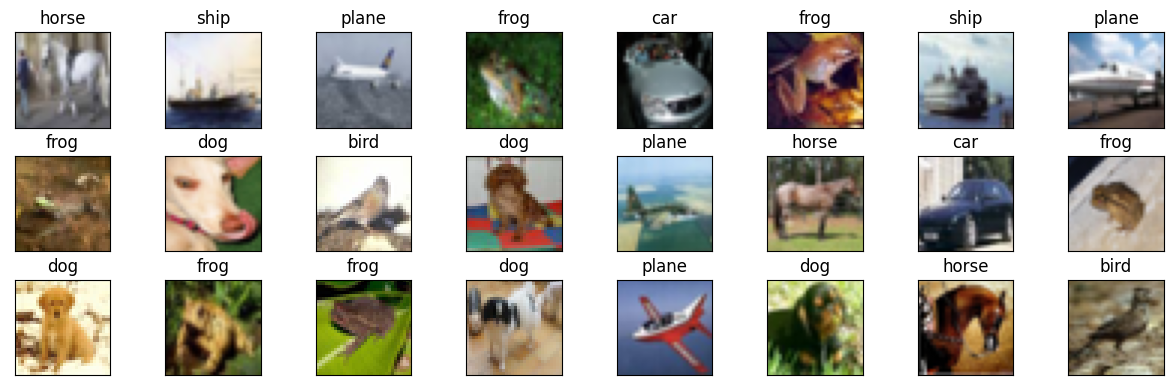

In [9]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

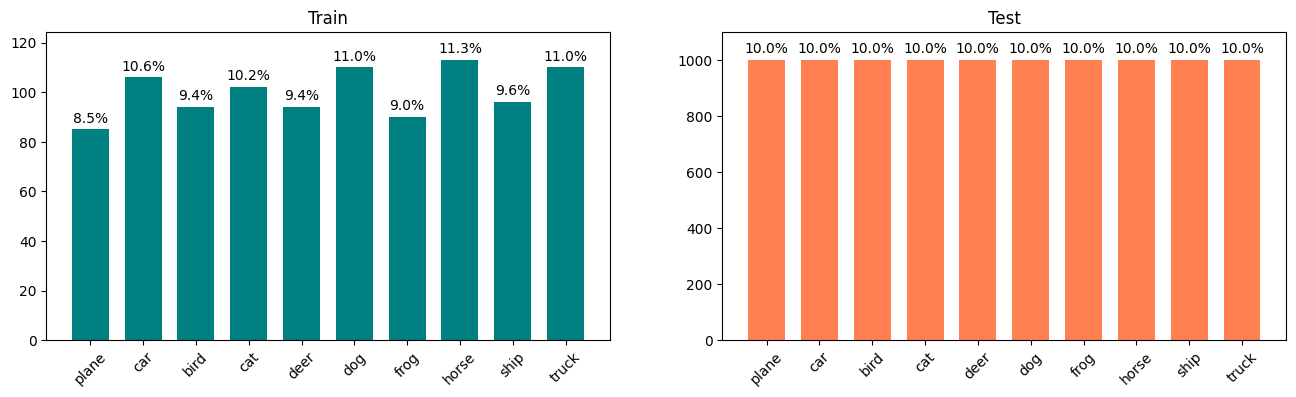

In [10]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [11]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [12]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [13]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

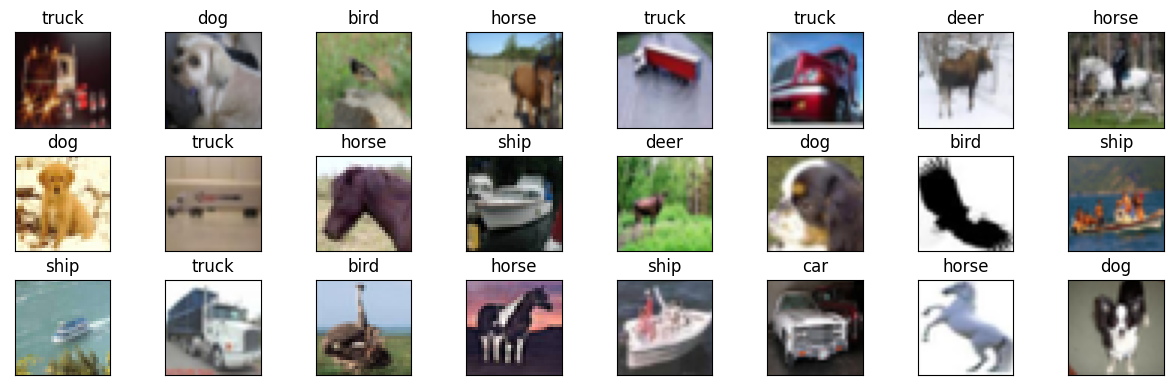

In [14]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [15]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

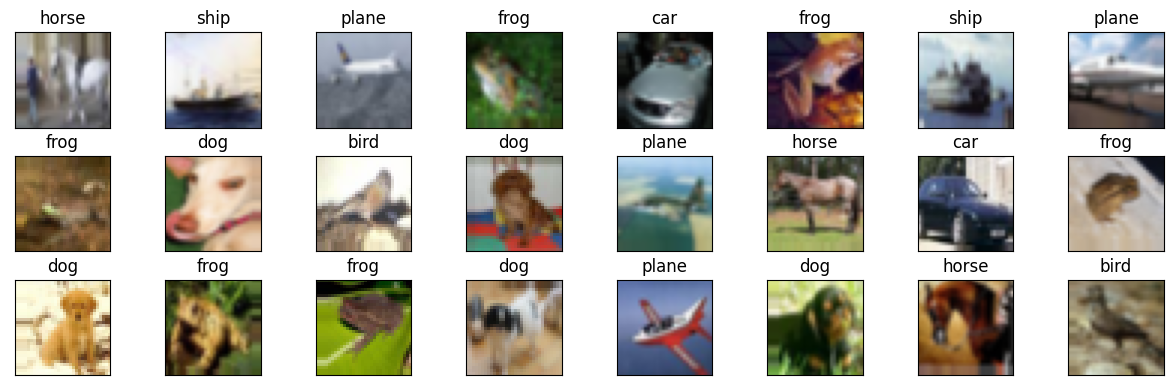

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

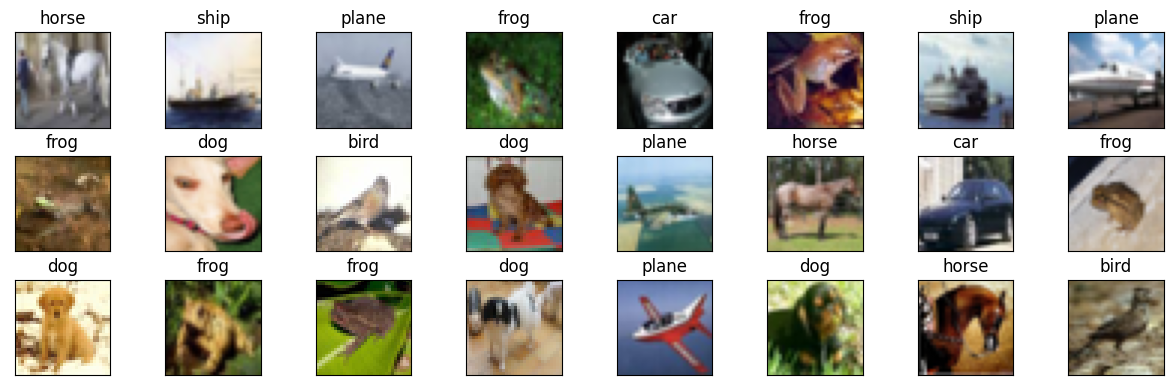

In [17]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [18]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [19]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


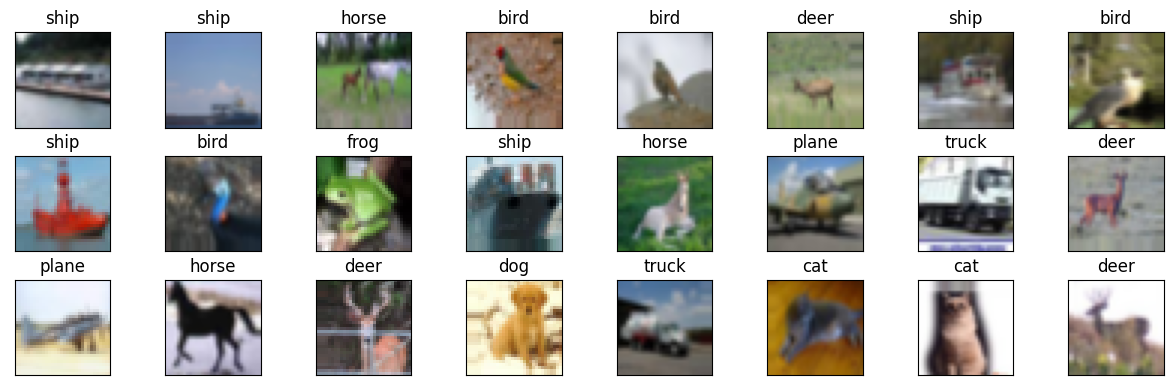

In [20]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2022-08-09 12:23:13,009: INFO: model_params.mlp1.dropout=0.1
2022-08-09 12:23:13,010: INFO: model_params.mlp1.layer_count=1
2022-08-09 12:23:13,011: INFO: model_params.mlp1.units=128
2022-08-09 12:23:13,052: INFO: learning_rate=0.001
2022-08-09 12:23:13,053: INFO: model_params.mlp1.clip_value=None
2022-08-09 12:23:13,062: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
___________________________________________________________

2022-08-09 12:23:13,075: INFO: model_params.mlp1.epochs=120
2022-08-09 12:23:13,075: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1, monitor=val_accuracy)
2022-08-09 12:23:13,076: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:23:13,077: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:23:13,077: INFO: use LearningRateScheduler()
2022-08-09 12:23:13,078: INFO: steps_per_epoch=31
2022-08-09 12:23:13,079: INFO: start training
2022-08-09 12:23:13,079: INFO: use_class_weight=False


Epoch 1/120
23/31 [=====================>........] - ETA: 0s - loss: 2.6035 - accuracy: 0.1318 INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:15,606: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 3s 58ms/step - loss: 2.5203 - accuracy: 0.1452 - val_loss: 2.1916 - val_accuracy: 0.1905 - lr: 0.0010
Epoch 2/120
22/31 [====================>.........] - ETA: 0s - loss: 2.1625 - accuracy: 0.1989INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:16,931: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 43ms/step - loss: 2.1548 - accuracy: 0.1996 - val_loss: 2.1796 - val_accuracy: 0.1946 - lr: 0.0010
Epoch 3/120
24/31 [======================>.......] - ETA: 0s - loss: 2.0992 - accuracy: 0.2070INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:18,246: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 43ms/step - loss: 2.0979 - accuracy: 0.2157 - val_loss: 2.0758 - val_accuracy: 0.2221 - lr: 0.0010
Epoch 4/120
23/31 [=====================>........] - ETA: 0s - loss: 2.0539 - accuracy: 0.2242INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:19,625: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 46ms/step - loss: 2.0431 - accuracy: 0.2308 - val_loss: 2.0550 - val_accuracy: 0.2335 - lr: 0.0010
Epoch 5/120
22/31 [====================>.........] - ETA: 0s - loss: 1.9880 - accuracy: 0.2713INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:21,133: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 2s 50ms/step - loss: 1.9796 - accuracy: 0.2792 - val_loss: 2.0245 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 6/120
31/31 [==============================] - 1s 23ms/step - loss: 1.9504 - accuracy: 0.3095 - val_loss: 2.0367 - val_accuracy: 0.2412 - lr: 0.0010
Epoch 7/120
24/31 [======================>.......] - ETA: 0s - loss: 1.9376 - accuracy: 0.3034INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:23,189: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 45ms/step - loss: 1.9274 - accuracy: 0.3014 - val_loss: 2.0169 - val_accuracy: 0.2577 - lr: 0.0010
Epoch 8/120
22/31 [====================>.........] - ETA: 0s - loss: 1.9292 - accuracy: 0.2940INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:24,519: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 44ms/step - loss: 1.9200 - accuracy: 0.2923 - val_loss: 2.0023 - val_accuracy: 0.2689 - lr: 0.0010
Epoch 9/120
22/31 [====================>.........] - ETA: 0s - loss: 1.8502 - accuracy: 0.3423INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:25,944: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 47ms/step - loss: 1.8563 - accuracy: 0.3327 - val_loss: 1.9758 - val_accuracy: 0.2827 - lr: 0.0010
Epoch 10/120
31/31 [==============================] - 1s 22ms/step - loss: 1.8661 - accuracy: 0.3256 - val_loss: 1.9751 - val_accuracy: 0.2755 - lr: 0.0010
Epoch 11/120
31/31 [==============================] - 1s 21ms/step - loss: 1.8149 - accuracy: 0.3347 - val_loss: 1.9644 - val_accuracy: 0.2791 - lr: 0.0010
Epoch 12/120
31/31 [==============================] - 1s 21ms/step - loss: 1.8054 - accuracy: 0.3538 - val_loss: 1.9564 - val_accuracy: 0.2770 - lr: 0.0010
Epoch 13/120
23/31 [=====================>........] - ETA: 0s - loss: 1.7821 - accuracy: 0.3519INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:29,207: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 44ms/step - loss: 1.7741 - accuracy: 0.3508 - val_loss: 1.9510 - val_accuracy: 0.2881 - lr: 0.0010
Epoch 14/120
31/31 [==============================] - 1s 22ms/step - loss: 1.7840 - accuracy: 0.3599 - val_loss: 1.9531 - val_accuracy: 0.2808 - lr: 0.0010
Epoch 15/120
31/31 [==============================] - 1s 21ms/step - loss: 1.7585 - accuracy: 0.3740 - val_loss: 1.9524 - val_accuracy: 0.2811 - lr: 0.0010
Epoch 16/120
31/31 [==============================] - 1s 22ms/step - loss: 1.7401 - accuracy: 0.3911 - val_loss: 1.9525 - val_accuracy: 0.2809 - lr: 0.0010
Epoch 17/120
24/31 [======================>.......] - ETA: 0s - loss: 1.7425 - accuracy: 0.3698INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:32,548: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 44ms/step - loss: 1.7450 - accuracy: 0.3720 - val_loss: 1.9445 - val_accuracy: 0.2924 - lr: 0.0010
Epoch 18/120
31/31 [==============================] - 1s 23ms/step - loss: 1.7376 - accuracy: 0.3831 - val_loss: 1.9673 - val_accuracy: 0.2716 - lr: 0.0010
Epoch 19/120
31/31 [==============================] - 1s 21ms/step - loss: 1.6910 - accuracy: 0.3881 - val_loss: 1.9583 - val_accuracy: 0.2831 - lr: 0.0010
Epoch 20/120
31/31 [==============================] - 1s 22ms/step - loss: 1.6804 - accuracy: 0.3861 - val_loss: 1.9630 - val_accuracy: 0.2717 - lr: 0.0010
Epoch 21/120
31/31 [==============================] - 1s 22ms/step - loss: 1.6628 - accuracy: 0.3931 - val_loss: 1.9549 - val_accuracy: 0.2891 - lr: 0.0010
Epoch 22/120
31/31 [==============================] - 1s 22ms/step - loss: 1.6465 - accuracy: 0.4002 - val_loss: 1.9486 - val_accuracy: 0.2872 - lr: 0.0010
Epoch 23/120
23/31 [=====================>........] - ETA: 0s - loss: 1.6406 

2022-08-09 12:23:37,229: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 44ms/step - loss: 1.6416 - accuracy: 0.4183 - val_loss: 1.9344 - val_accuracy: 0.2956 - lr: 0.0010
Epoch 24/120
22/31 [====================>.........] - ETA: 0s - loss: 1.6336 - accuracy: 0.4389INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:38,549: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 44ms/step - loss: 1.6266 - accuracy: 0.4315 - val_loss: 1.9333 - val_accuracy: 0.3083 - lr: 0.0010
Epoch 25/120
31/31 [==============================] - 1s 22ms/step - loss: 1.5885 - accuracy: 0.4163 - val_loss: 1.9413 - val_accuracy: 0.2999 - lr: 0.0010
Epoch 26/120
31/31 [==============================] - 1s 22ms/step - loss: 1.5770 - accuracy: 0.4456 - val_loss: 1.9535 - val_accuracy: 0.3055 - lr: 0.0010
Epoch 27/120
31/31 [==============================] - 1s 22ms/step - loss: 1.5962 - accuracy: 0.4415 - val_loss: 1.9717 - val_accuracy: 0.2890 - lr: 0.0010
Epoch 28/120
31/31 [==============================] - 1s 23ms/step - loss: 1.5725 - accuracy: 0.4375 - val_loss: 1.9929 - val_accuracy: 0.2887 - lr: 0.0010
Epoch 29/120
31/31 [==============================] - 1s 22ms/step - loss: 1.5401 - accuracy: 0.4496 - val_loss: 1.9650 - val_accuracy: 0.3011 - lr: 0.0010
Epoch 30/120
31/31 [==============================] - 1s 22ms/step - loss: 1.

2022-08-09 12:23:48,718: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 44ms/step - loss: 1.4117 - accuracy: 0.4808 - val_loss: 1.9758 - val_accuracy: 0.3090 - lr: 0.0010
Epoch 39/120
23/31 [=====================>........] - ETA: 0s - loss: 1.4087 - accuracy: 0.4946
Epoch 39: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
31/31 [==============================] - 1s 22ms/step - loss: 1.4065 - accuracy: 0.4929 - val_loss: 1.9909 - val_accuracy: 0.3024 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/120
20/31 [==================>...........] - ETA: 0s - loss: 1.4013 - accuracy: 0.5188INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:50,843: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 48ms/step - loss: 1.4018 - accuracy: 0.5131 - val_loss: 2.0168 - val_accuracy: 0.3146 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/120
22/31 [====================>.........] - ETA: 0s - loss: 1.3673 - accuracy: 0.5057INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:52,413: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 2s 52ms/step - loss: 1.3780 - accuracy: 0.5081 - val_loss: 2.0117 - val_accuracy: 0.3191 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/120
24/31 [======================>.......] - ETA: 0s - loss: 1.3950 - accuracy: 0.5208INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


2022-08-09 12:23:53,713: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1/assets


31/31 [==============================] - 1s 43ms/step - loss: 1.3968 - accuracy: 0.5131 - val_loss: 2.0015 - val_accuracy: 0.3229 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/120
31/31 [==============================] - 1s 22ms/step - loss: 1.3661 - accuracy: 0.5212 - val_loss: 2.0114 - val_accuracy: 0.3155 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/120
31/31 [==============================] - 1s 22ms/step - loss: 1.3846 - accuracy: 0.5212 - val_loss: 2.0011 - val_accuracy: 0.3135 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/120
31/31 [==============================] - 1s 22ms/step - loss: 1.3781 - accuracy: 0.5202 - val_loss: 2.0185 - val_accuracy: 0.3157 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/120
31/31 [==============================] - 1s 22ms/step - loss: 1.3358 - accuracy: 0.5272 - val_loss: 

31/31 [==============================] - 1s 21ms/step - loss: 1.2381 - accuracy: 0.5716 - val_loss: 2.0127 - val_accuracy: 0.3166 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
31/31 [==============================] - 1s 21ms/step - loss: 1.2351 - accuracy: 0.5716 - val_loss: 2.0127 - val_accuracy: 0.3169 - lr: 3.1623e-05
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 82/120
31/31 [==============================] - 1s 20ms/step - loss: 1.2336 - accuracy: 0.5756 - val_loss: 2.0112 - val_accuracy: 0.3165 - lr: 3.1623e-05
Epoch 82: early stopping


2022-08-09 12:24:20,205: INFO: finish training [elapsed time: 67.13 seconds]


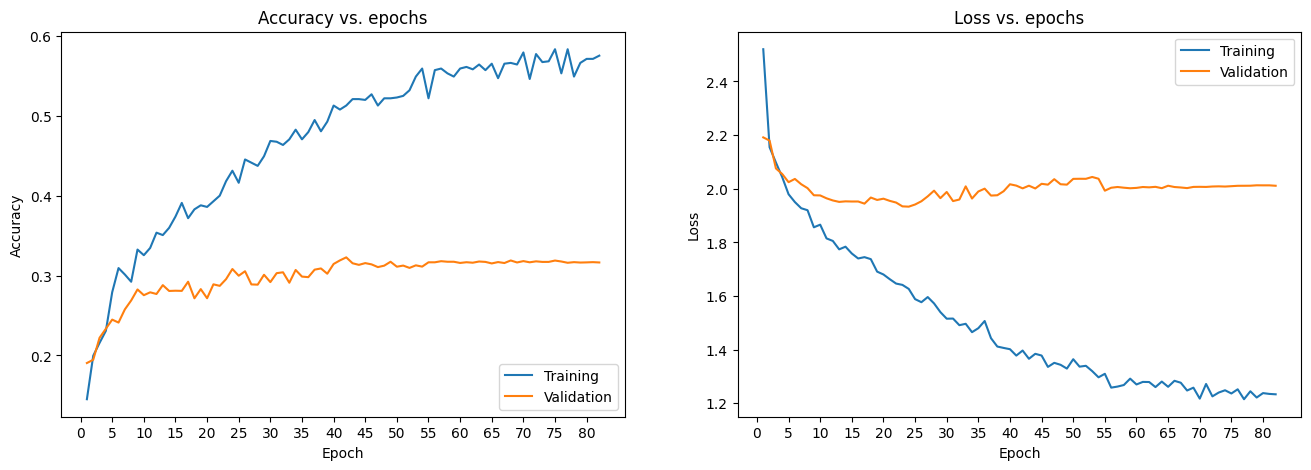

2022-08-09 12:24:20,609: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 1ms/step


2022-08-09 12:24:24,171: INFO: test loss:2.0015
2022-08-09 12:24:24,172: INFO: test accuracy:0.3229
2022-08-09 12:24:24,173: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json
2022-08-09 12:24:24,175: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json
2022-08-09 12:24:24,176: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:24:24,177: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:24:24,178: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/le

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:24:25,015: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator


313/313 [==============================] - 2s 2ms/step


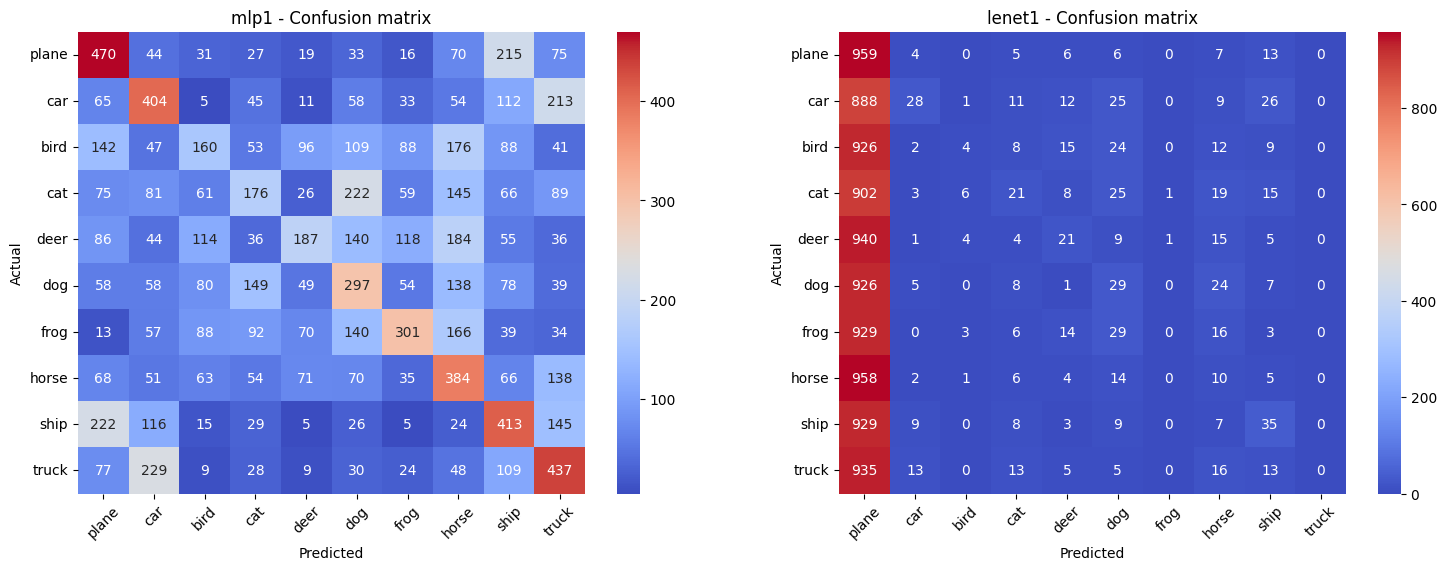

2022-08-09 12:24:30,210: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:24:31,253: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:24:31,256: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1
2022-08-09 12:24:32,193: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:24:32,196: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8
2022-08-09 12:24:33,747: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator


1/1 [==============================] - 0s 13ms/step


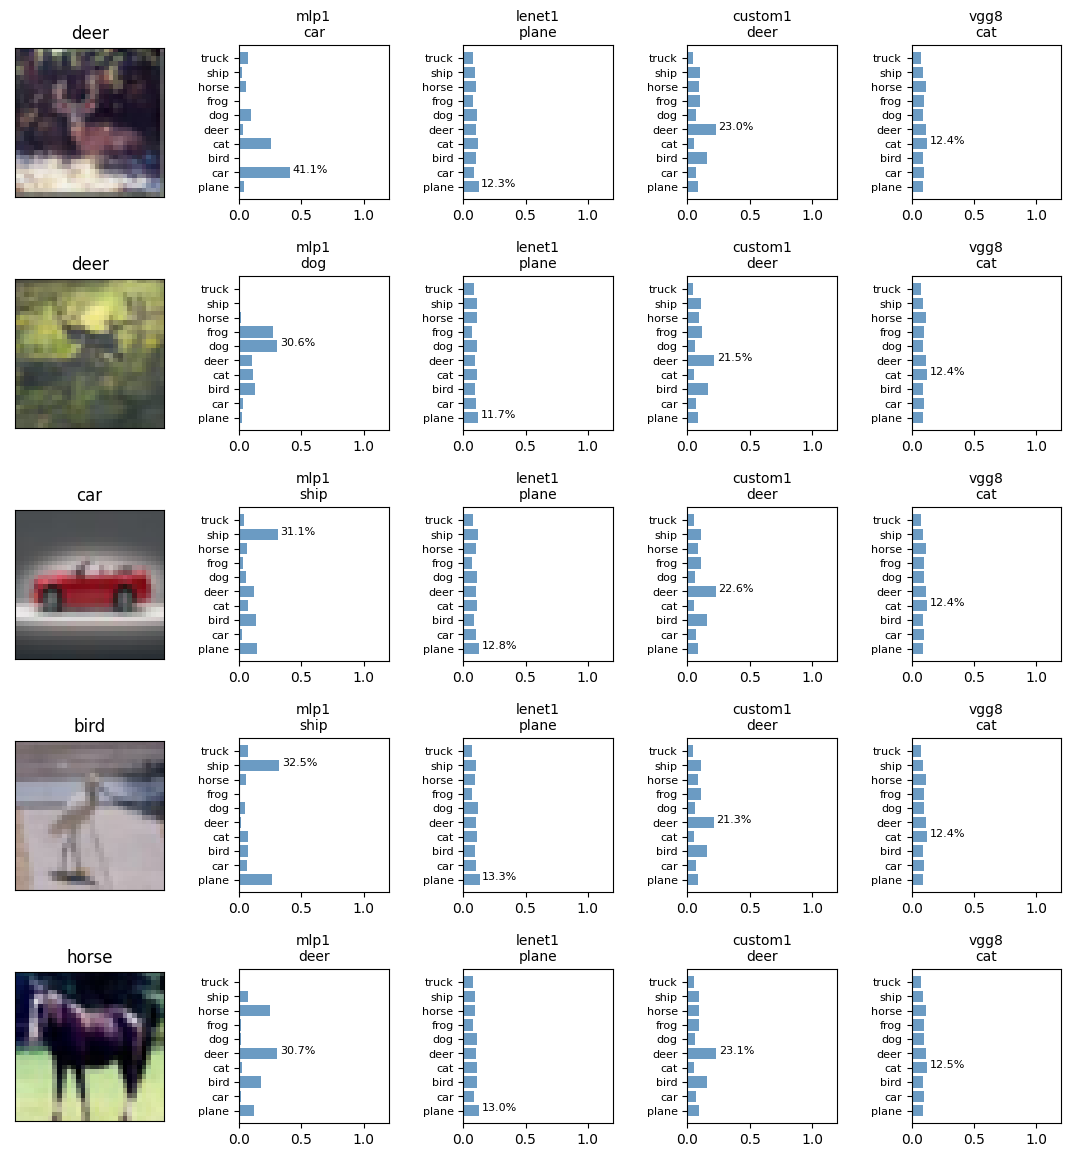

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1       mlp1  cifar10_0808_count_100.ipynb         394634        67.1   
2     lenet1  cifar10_0808_count_100.ipynb          83170         4.5   
3    custom1  cifar10_0808_count_100.ipynb          73738         4.8   
4       vgg8  cifar10_0808_count_100.ipynb        1672906         6.8   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:24      1.2734     2.0015           0.590         0.3229   
2  2022-08-09 05:40      2.2958     2.2925           0.097         0.1107   
3  2022-08-09 05:40      2.4003     2.3805           0.094         0.1000   
4  2022-08-09 05:40      2.3093     2.3088           0.102         0.1000   

   train_auc  test_auc  
1     0.9115    0.7675  
2     0.6038    0.6093  
3     0.6716    0.6530  
4     0.6227    0.6196

In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2022-08-09 12:24:39,404: INFO: model_params.lenet1.dropout=0.2
2022-08-09 12:24:39,496: INFO: learning_rate=0.001
2022-08-09 12:24:39,497: INFO: model_params.lenet1.clip_value=None
2022-08-09 12:24:39,503: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0         
                                                               

2022-08-09 12:24:39,530: INFO: model_params.lenet1.epochs=120
2022-08-09 12:24:39,531: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1, monitor=val_accuracy)
2022-08-09 12:24:39,531: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:24:39,532: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:24:39,533: INFO: use LearningRateScheduler()
2022-08-09 12:24:39,533: INFO: steps_per_epoch=31
2022-08-09 12:24:39,534: INFO: start training
2022-08-09 12:24:39,535: INFO: use_class_weight=False


Epoch 1/120
27/31 [=========================>....] - ETA: 0s - loss: 2.7076 - accuracy: 0.1285

2022-08-09 12:24:42,675: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:24:43,293: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 4s 98ms/step - loss: 2.6530 - accuracy: 0.1331 - val_loss: 2.2803 - val_accuracy: 0.1574 - lr: 0.0010
Epoch 2/120
31/31 [==============================] - 1s 49ms/step - loss: 2.1380 - accuracy: 0.2268 - val_loss: 2.2508 - val_accuracy: 0.1283 - lr: 0.0010
Epoch 3/120
30/31 [============================>.] - ETA: 0s - loss: 1.9904 - accuracy: 0.2729

2022-08-09 12:24:47,163: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:24:47,780: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 100ms/step - loss: 1.9866 - accuracy: 0.2732 - val_loss: 2.1643 - val_accuracy: 0.1918 - lr: 0.0010
Epoch 4/120
27/31 [=========================>....] - ETA: 0s - loss: 1.9123 - accuracy: 0.3137

2022-08-09 12:24:50,229: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:24:50,833: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 102ms/step - loss: 1.8927 - accuracy: 0.3115 - val_loss: 2.1051 - val_accuracy: 0.2081 - lr: 0.0010
Epoch 5/120
31/31 [==============================] - ETA: 0s - loss: 1.8208 - accuracy: 0.3468

2022-08-09 12:24:53,183: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:24:53,793: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 98ms/step - loss: 1.8208 - accuracy: 0.3468 - val_loss: 2.0889 - val_accuracy: 0.2229 - lr: 0.0010
Epoch 6/120
31/31 [==============================] - 1s 29ms/step - loss: 1.6955 - accuracy: 0.4002 - val_loss: 2.1269 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 7/120
27/31 [=========================>....] - ETA: 0s - loss: 1.7033 - accuracy: 0.3935

2022-08-09 12:24:57,123: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:24:57,726: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 101ms/step - loss: 1.6739 - accuracy: 0.4042 - val_loss: 2.0953 - val_accuracy: 0.2373 - lr: 0.0010
Epoch 8/120
27/31 [=========================>....] - ETA: 0s - loss: 1.5877 - accuracy: 0.4271

2022-08-09 12:24:59,824: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:00,415: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 89ms/step - loss: 1.5865 - accuracy: 0.4315 - val_loss: 2.1528 - val_accuracy: 0.2412 - lr: 0.0010
Epoch 9/120
26/31 [========================>.....] - ETA: 0s - loss: 1.5543 - accuracy: 0.4435

2022-08-09 12:25:03,357: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:03,989: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 4s 119ms/step - loss: 1.5465 - accuracy: 0.4466 - val_loss: 2.0958 - val_accuracy: 0.2601 - lr: 0.0010
Epoch 10/120
31/31 [==============================] - 1s 37ms/step - loss: 1.4886 - accuracy: 0.4829 - val_loss: 2.4891 - val_accuracy: 0.2110 - lr: 0.0010
Epoch 11/120
27/31 [=========================>....] - ETA: 0s - loss: 1.4036 - accuracy: 0.5116

2022-08-09 12:25:07,269: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:07,895: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 92ms/step - loss: 1.3878 - accuracy: 0.5141 - val_loss: 1.9751 - val_accuracy: 0.3210 - lr: 0.0010
Epoch 12/120
31/31 [==============================] - 1s 29ms/step - loss: 1.3696 - accuracy: 0.5101 - val_loss: 2.0701 - val_accuracy: 0.3014 - lr: 0.0010
Epoch 13/120
31/31 [==============================] - 1s 46ms/step - loss: 1.2841 - accuracy: 0.5423 - val_loss: 2.2919 - val_accuracy: 0.2770 - lr: 0.0010
Epoch 14/120
31/31 [==============================] - 1s 39ms/step - loss: 1.2333 - accuracy: 0.5706 - val_loss: 2.3563 - val_accuracy: 0.2709 - lr: 0.0010
Epoch 15/120
27/31 [=========================>....] - ETA: 0s - loss: 1.1984 - accuracy: 0.5556

2022-08-09 12:25:13,469: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:14,042: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 90ms/step - loss: 1.1787 - accuracy: 0.5615 - val_loss: 1.9739 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 16/120
27/31 [=========================>....] - ETA: 0s - loss: 1.1342 - accuracy: 0.5833

2022-08-09 12:25:16,727: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:17,323: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 109ms/step - loss: 1.1199 - accuracy: 0.5887 - val_loss: 2.1233 - val_accuracy: 0.3339 - lr: 0.0010
Epoch 17/120
27/31 [=========================>....] - ETA: 0s - loss: 1.0868 - accuracy: 0.5995

2022-08-09 12:25:19,429: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:20,040: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 90ms/step - loss: 1.0816 - accuracy: 0.6069 - val_loss: 1.9038 - val_accuracy: 0.3737 - lr: 0.0010
Epoch 18/120
31/31 [==============================] - ETA: 0s - loss: 1.0128 - accuracy: 0.6411

2022-08-09 12:25:22,808: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:23,422: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 112ms/step - loss: 1.0128 - accuracy: 0.6411 - val_loss: 1.8486 - val_accuracy: 0.3938 - lr: 0.0010
Epoch 19/120
27/31 [=========================>....] - ETA: 0s - loss: 1.0160 - accuracy: 0.6505

2022-08-09 12:25:25,597: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:26,207: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 92ms/step - loss: 1.0261 - accuracy: 0.6492 - val_loss: 1.8639 - val_accuracy: 0.3941 - lr: 0.0010
Epoch 20/120
31/31 [==============================] - 1s 49ms/step - loss: 0.9517 - accuracy: 0.6694 - val_loss: 2.0167 - val_accuracy: 0.3694 - lr: 0.0010
Epoch 21/120
31/31 [==============================] - 1s 46ms/step - loss: 0.8807 - accuracy: 0.6956 - val_loss: 2.1459 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 22/120
30/31 [============================>.] - ETA: 0s - loss: 0.8623 - accuracy: 0.6802

2022-08-09 12:25:32,222: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:32,841: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 4s 124ms/step - loss: 0.8567 - accuracy: 0.6835 - val_loss: 1.9613 - val_accuracy: 0.3953 - lr: 0.0010
Epoch 23/120
31/31 [==============================] - 1s 29ms/step - loss: 0.7774 - accuracy: 0.7228 - val_loss: 1.9541 - val_accuracy: 0.3913 - lr: 0.0010
Epoch 24/120
27/31 [=========================>....] - ETA: 0s - loss: 0.7759 - accuracy: 0.7025

2022-08-09 12:25:35,897: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:36,505: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 92ms/step - loss: 0.7564 - accuracy: 0.7188 - val_loss: 2.0714 - val_accuracy: 0.3987 - lr: 0.0010
Epoch 25/120
29/31 [===========================>..] - ETA: 0s - loss: 0.7263 - accuracy: 0.7435

2022-08-09 12:25:39,322: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:39,929: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 113ms/step - loss: 0.7326 - accuracy: 0.7440 - val_loss: 1.9558 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 26/120
31/31 [==============================] - 1s 29ms/step - loss: 0.6863 - accuracy: 0.7631 - val_loss: 2.0712 - val_accuracy: 0.3961 - lr: 0.0010
Epoch 27/120
31/31 [==============================] - 1s 32ms/step - loss: 0.6379 - accuracy: 0.7792 - val_loss: 2.0888 - val_accuracy: 0.4026 - lr: 0.0010
Epoch 28/120
31/31 [==============================] - 2s 50ms/step - loss: 0.6374 - accuracy: 0.7692 - val_loss: 2.2303 - val_accuracy: 0.3973 - lr: 0.0010
Epoch 29/120
31/31 [==============================] - 1s 45ms/step - loss: 0.5664 - accuracy: 0.7974 - val_loss: 2.1801 - val_accuracy: 0.4011 - lr: 0.0010
Epoch 30/120
31/31 [==============================] - 1s 48ms/step - loss: 0.5785 - accuracy: 0.7923 - val_loss: 2.1390 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 31/120
31/31 [==============================] - 1s 48ms/step - loss: 0

2022-08-09 12:25:50,614: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:51,225: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets



Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
31/31 [==============================] - 3s 93ms/step - loss: 0.4823 - accuracy: 0.8438 - val_loss: 2.2246 - val_accuracy: 0.4057 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/120
26/31 [========================>.....] - ETA: 0s - loss: 0.4327 - accuracy: 0.8630

2022-08-09 12:25:53,924: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:25:54,533: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 110ms/step - loss: 0.4436 - accuracy: 0.8558 - val_loss: 2.2382 - val_accuracy: 0.4115 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/120
31/31 [==============================] - 1s 49ms/step - loss: 0.4467 - accuracy: 0.8397 - val_loss: 2.2485 - val_accuracy: 0.4003 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/120
31/31 [==============================] - 1s 49ms/step - loss: 0.4195 - accuracy: 0.8579 - val_loss: 2.2097 - val_accuracy: 0.4082 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/120
28/31 [==========================>...] - ETA: 0s - loss: 0.3692 - accuracy: 0.8683

2022-08-09 12:25:59,852: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:26:00,467: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 98ms/step - loss: 0.3724 - accuracy: 0.8669 - val_loss: 2.2308 - val_accuracy: 0.4174 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/120
27/31 [=========================>....] - ETA: 0s - loss: 0.4069 - accuracy: 0.8704

2022-08-09 12:26:02,656: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:26:03,258: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 93ms/step - loss: 0.3845 - accuracy: 0.8780 - val_loss: 2.2646 - val_accuracy: 0.4180 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/120
31/31 [==============================] - 1s 46ms/step - loss: 0.3532 - accuracy: 0.8841 - val_loss: 2.3710 - val_accuracy: 0.4011 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/120
31/31 [==============================] - 1s 40ms/step - loss: 0.3313 - accuracy: 0.8962 - val_loss: 2.3456 - val_accuracy: 0.4112 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/120
31/31 [==============================] - 1s 29ms/step - loss: 0.3913 - accuracy: 0.8700 - val_loss: 2.3168 - val_accuracy: 0.4124 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/120
31/31 [==============================] - 1s 29ms/step - loss: 0.3140 - accuracy: 0.8891 - val_loss: 

2022-08-09 12:26:20,997: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:26:21,879: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 4s 126ms/step - loss: 0.3010 - accuracy: 0.8972 - val_loss: 2.3895 - val_accuracy: 0.4181 - lr: 1.0000e-04
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
Epoch 52/120
29/31 [===========================>..] - ETA: 0s - loss: 0.3031 - accuracy: 0.8976

2022-08-09 12:26:24,020: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


2022-08-09 12:26:24,632: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1/assets


31/31 [==============================] - 3s 91ms/step - loss: 0.3070 - accuracy: 0.8982 - val_loss: 2.3820 - val_accuracy: 0.4242 - lr: 1.0000e-04
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
Epoch 53/120
31/31 [==============================] - 1s 48ms/step - loss: 0.2712 - accuracy: 0.9022 - val_loss: 2.3770 - val_accuracy: 0.4200 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/120
31/31 [==============================] - 2s 50ms/step - loss: 0.3261 - accuracy: 0.8891 - val_loss: 2.4004 - val_accuracy: 0.4170 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/120
31/31 [==============================] - 2s 51ms/step - loss: 0.2798 - accuracy: 0.9113 - val_loss: 2.3696 - val_accuracy: 0.4176 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/120
31/31 [==============================] - 1s 35ms/step - loss: 0.2685 - accuracy: 0.9113 - val_loss: 2.3968 - val

2022-08-09 12:27:16,090: INFO: finish training [elapsed time: 156.56 seconds]


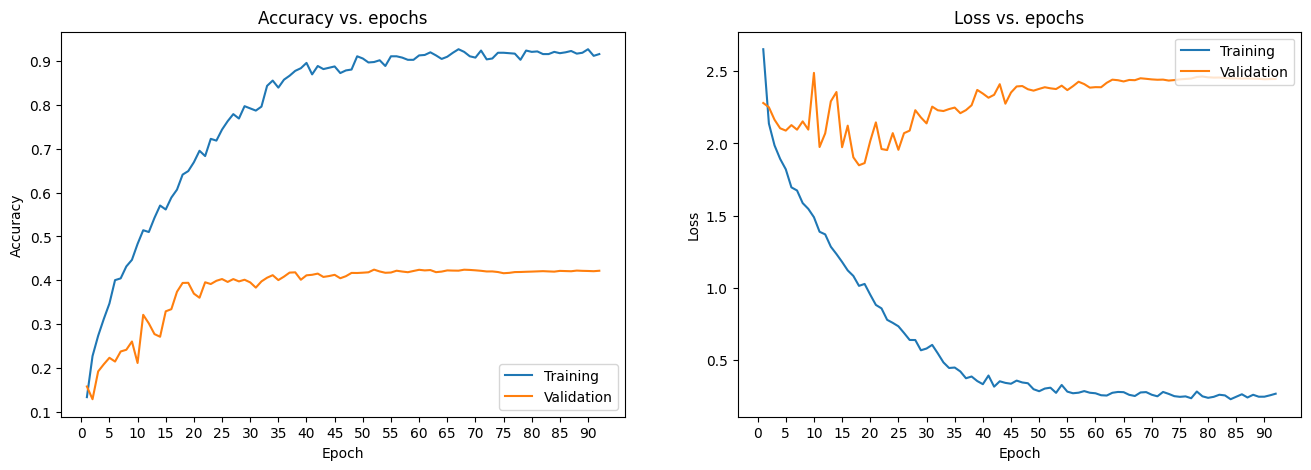

2022-08-09 12:27:16,583: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-09 12:27:22,093: INFO: test loss:2.3820
2022-08-09 12:27:22,094: INFO: test accuracy:0.4242
2022-08-09 12:27:22,096: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json
2022-08-09 12:27:22,097: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json
2022-08-09 12:27:22,098: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:27:22,099: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:27:22,099: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/ml

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:27:22,420: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator


313/313 [==============================] - 1s 2ms/step


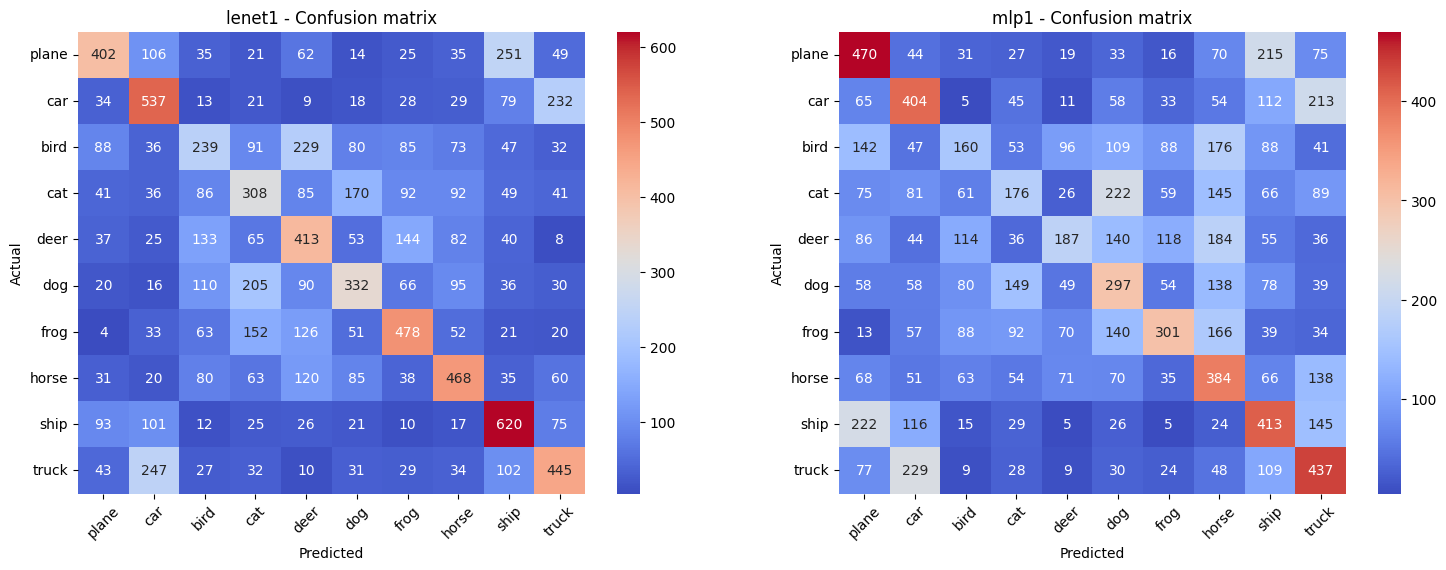

2022-08-09 12:27:27,201: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:27:27,504: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:27:27,505: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1
2022-08-09 12:27:28,880: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:27:28,882: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8
2022-08-09 12:27:30,534: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator


1/1 [==============================] - 0s 12ms/step


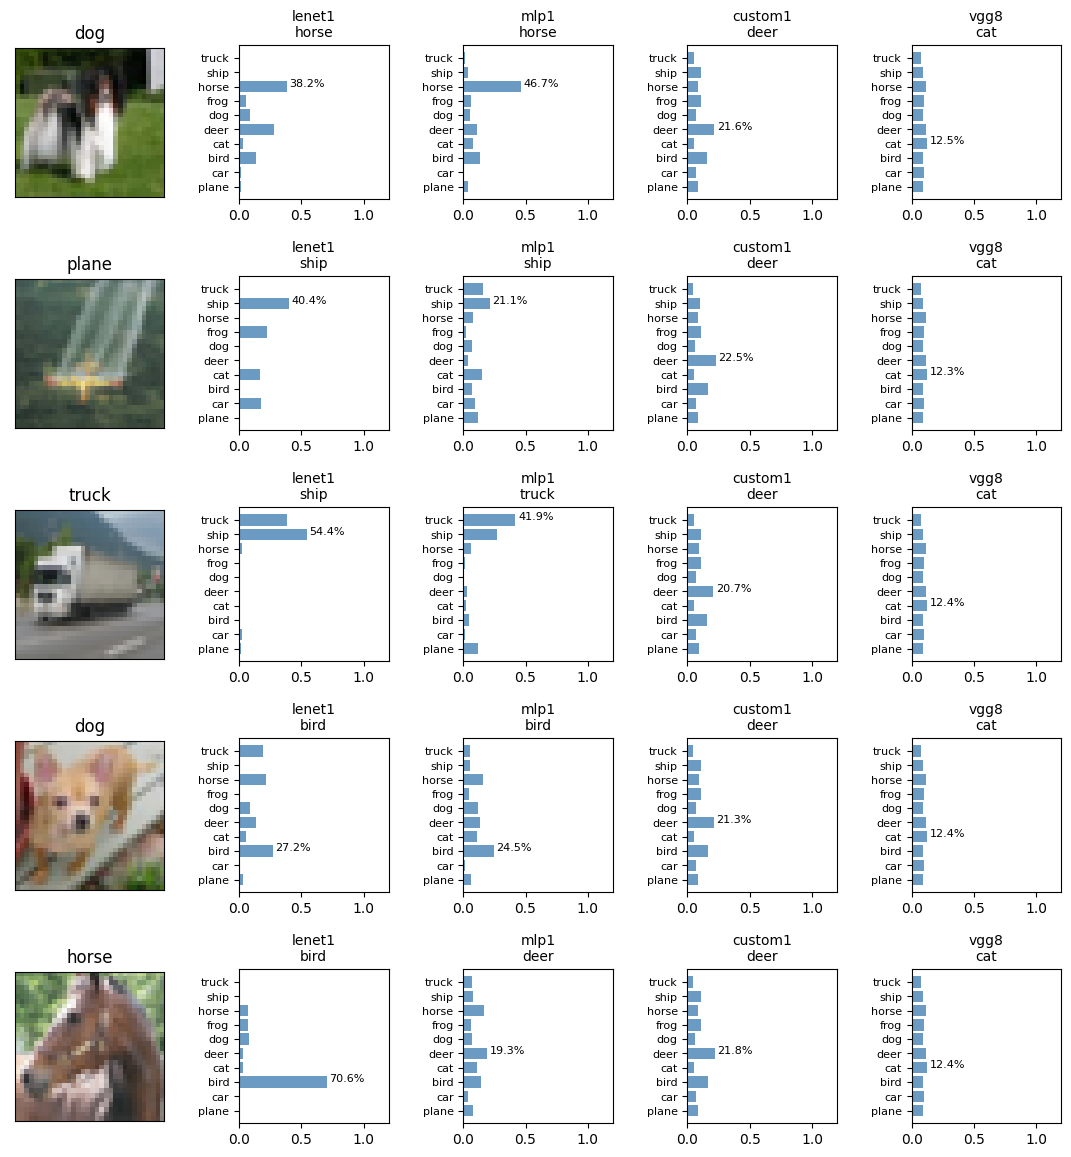

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1     lenet1  cifar10_0808_count_100.ipynb          83170       156.6   
2       mlp1  cifar10_0808_count_100.ipynb         394634        67.1   
3    custom1  cifar10_0808_count_100.ipynb          73738         4.8   
4       vgg8  cifar10_0808_count_100.ipynb        1672906         6.8   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:27      0.0511     2.3820           0.993         0.4242   
2  2022-08-09 12:24      1.2734     2.0015           0.590         0.3229   
3  2022-08-09 05:40      2.4003     2.3805           0.094         0.1000   
4  2022-08-09 05:40      2.3093     2.3088           0.102         0.1000   

   train_auc  test_auc  
1     1.0000    0.8297  
2     0.9115    0.7675  
3     0.6716    0.6530  
4     0.6227    0.6196

In [22]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2022-08-09 12:27:36,163: INFO: model_params.custom1.dropout=0.2
2022-08-09 12:27:36,273: INFO: learning_rate=0.001
2022-08-09 12:27:36,274: INFO: model_params.custom1.clip_value=None
2022-08-09 12:27:36,281: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                              

2022-08-09 12:27:36,314: INFO: model_params.custom1.epochs=120
2022-08-09 12:27:36,315: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1, monitor=val_accuracy)
2022-08-09 12:27:36,316: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:27:36,316: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:27:36,317: INFO: use LearningRateScheduler()
2022-08-09 12:27:36,317: INFO: steps_per_epoch=31
2022-08-09 12:27:36,318: INFO: start training
2022-08-09 12:27:36,319: INFO: use_class_weight=False


Epoch 1/120
23/31 [=====================>........] - ETA: 0s - loss: 2.8079 - accuracy: 0.1277

2022-08-09 12:27:40,315: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:27:40,993: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 5s 115ms/step - loss: 2.6830 - accuracy: 0.1452 - val_loss: 2.2911 - val_accuracy: 0.1005 - lr: 0.0010
Epoch 2/120
31/31 [==============================] - 1s 36ms/step - loss: 2.0605 - accuracy: 0.2772 - val_loss: 2.5341 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/120
31/31 [==============================] - 1s 32ms/step - loss: 1.9230 - accuracy: 0.2974 - val_loss: 2.8156 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/120
31/31 [==============================] - 1s 32ms/step - loss: 1.8004 - accuracy: 0.3438 - val_loss: 3.0903 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/120
31/31 [==============================] - 1s 33ms/step - loss: 1.7030 - accuracy: 0.3861 - val_loss: 3.2927 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/120
31/31 [==============================] - 2s 50ms/step - loss: 1.6286 - accuracy: 0.3982 - val_loss: 3.3769 - val_accuracy: 0.1002 - lr: 0.0010
Epoch 7/120
29/31 [===========================>..] - ETA: 0s - loss: 1.5533 - acc

2022-08-09 12:27:49,551: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:27:50,234: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 122ms/step - loss: 1.5583 - accuracy: 0.4385 - val_loss: 3.3669 - val_accuracy: 0.1019 - lr: 0.0010
Epoch 8/120
29/31 [===========================>..] - ETA: 0s - loss: 1.4944 - accuracy: 0.4569

2022-08-09 12:27:53,188: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:27:54,133: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 129ms/step - loss: 1.4968 - accuracy: 0.4536 - val_loss: 3.3145 - val_accuracy: 0.1032 - lr: 0.0010
Epoch 9/120
28/31 [==========================>...] - ETA: 0s - loss: 1.4169 - accuracy: 0.4788

2022-08-09 12:27:56,959: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:27:57,654: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 117ms/step - loss: 1.4216 - accuracy: 0.4758 - val_loss: 3.2942 - val_accuracy: 0.1139 - lr: 0.0010
Epoch 10/120
23/31 [=====================>........] - ETA: 0s - loss: 1.3482 - accuracy: 0.5068

2022-08-09 12:28:00,149: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:00,854: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 3s 106ms/step - loss: 1.3277 - accuracy: 0.5091 - val_loss: 3.2097 - val_accuracy: 0.1247 - lr: 0.0010
Epoch 11/120
28/31 [==========================>...] - ETA: 0s - loss: 1.2988 - accuracy: 0.5379

2022-08-09 12:28:03,566: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:04,256: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 3s 113ms/step - loss: 1.2881 - accuracy: 0.5333 - val_loss: 3.1707 - val_accuracy: 0.1437 - lr: 0.0010
Epoch 12/120
31/31 [==============================] - ETA: 0s - loss: 1.2501 - accuracy: 0.5655

2022-08-09 12:28:07,243: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:07,930: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 122ms/step - loss: 1.2501 - accuracy: 0.5655 - val_loss: 2.7442 - val_accuracy: 0.1702 - lr: 0.0010
Epoch 13/120
22/31 [====================>.........] - ETA: 0s - loss: 1.2321 - accuracy: 0.5526

2022-08-09 12:28:10,456: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:11,195: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 3s 108ms/step - loss: 1.2207 - accuracy: 0.5393 - val_loss: 2.6819 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 14/120
28/31 [==========================>...] - ETA: 0s - loss: 1.1779 - accuracy: 0.5993

2022-08-09 12:28:14,345: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:15,024: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 127ms/step - loss: 1.1745 - accuracy: 0.5857 - val_loss: 2.2579 - val_accuracy: 0.2636 - lr: 0.0010
Epoch 15/120
31/31 [==============================] - 2s 52ms/step - loss: 1.1247 - accuracy: 0.5998 - val_loss: 2.4069 - val_accuracy: 0.2578 - lr: 0.0010
Epoch 16/120
29/31 [===========================>..] - ETA: 0s - loss: 1.0445 - accuracy: 0.6304

2022-08-09 12:28:19,982: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:20,679: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 135ms/step - loss: 1.0414 - accuracy: 0.6250 - val_loss: 2.2371 - val_accuracy: 0.2806 - lr: 0.0010
Epoch 17/120
29/31 [===========================>..] - ETA: 0s - loss: 0.9899 - accuracy: 0.6649

2022-08-09 12:28:23,205: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:23,910: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 3s 107ms/step - loss: 0.9974 - accuracy: 0.6593 - val_loss: 1.8939 - val_accuracy: 0.3567 - lr: 0.0010
Epoch 18/120
31/31 [==============================] - 1s 32ms/step - loss: 0.9860 - accuracy: 0.6482 - val_loss: 2.2529 - val_accuracy: 0.2994 - lr: 0.0010
Epoch 19/120
31/31 [==============================] - 1s 47ms/step - loss: 0.9359 - accuracy: 0.6774 - val_loss: 2.1416 - val_accuracy: 0.3378 - lr: 0.0010
Epoch 20/120
31/31 [==============================] - 2s 50ms/step - loss: 0.9033 - accuracy: 0.6825 - val_loss: 2.4436 - val_accuracy: 0.3119 - lr: 0.0010
Epoch 21/120
29/31 [===========================>..] - ETA: 0s - loss: 0.8213 - accuracy: 0.7004

2022-08-09 12:28:31,108: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:31,792: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 131ms/step - loss: 0.8148 - accuracy: 0.7016 - val_loss: 1.9431 - val_accuracy: 0.3761 - lr: 0.0010
Epoch 22/120
31/31 [==============================] - 1s 32ms/step - loss: 0.8104 - accuracy: 0.7026 - val_loss: 2.0739 - val_accuracy: 0.3646 - lr: 0.0010
Epoch 23/120
31/31 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.7319

2022-08-09 12:28:35,821: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:36,538: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 125ms/step - loss: 0.7574 - accuracy: 0.7319 - val_loss: 1.7054 - val_accuracy: 0.4320 - lr: 0.0010
Epoch 24/120
31/31 [==============================] - 1s 49ms/step - loss: 0.7164 - accuracy: 0.7560 - val_loss: 1.8235 - val_accuracy: 0.4316 - lr: 0.0010
Epoch 25/120
31/31 [==============================] - 2s 51ms/step - loss: 0.6846 - accuracy: 0.7530 - val_loss: 2.2718 - val_accuracy: 0.3602 - lr: 0.0010
Epoch 26/120
31/31 [==============================] - 2s 53ms/step - loss: 0.6439 - accuracy: 0.7802 - val_loss: 2.1946 - val_accuracy: 0.3874 - lr: 0.0010
Epoch 27/120
31/31 [==============================] - 1s 50ms/step - loss: 0.6226 - accuracy: 0.7702 - val_loss: 2.3139 - val_accuracy: 0.3756 - lr: 0.0010
Epoch 28/120
31/31 [==============================] - 1s 50ms/step - loss: 0.5648 - accuracy: 0.8125 - val_loss: 2.1759 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 29/120
29/31 [===========================>..] - ETA: 0s - loss: 0.5780

2022-08-09 12:28:47,244: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:47,935: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 124ms/step - loss: 0.5738 - accuracy: 0.7954 - val_loss: 1.9266 - val_accuracy: 0.4348 - lr: 0.0010
Epoch 30/120
31/31 [==============================] - 2s 52ms/step - loss: 0.5457 - accuracy: 0.8196 - val_loss: 2.1009 - val_accuracy: 0.4242 - lr: 0.0010
Epoch 31/120
31/31 [==============================] - 2s 51ms/step - loss: 0.5458 - accuracy: 0.8085 - val_loss: 2.1657 - val_accuracy: 0.4070 - lr: 0.0010
Epoch 32/120
29/31 [===========================>..] - ETA: 0s - loss: 0.5322 - accuracy: 0.8050

2022-08-09 12:28:54,074: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:28:54,772: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 122ms/step - loss: 0.5309 - accuracy: 0.8054 - val_loss: 1.8631 - val_accuracy: 0.4526 - lr: 0.0010
Epoch 33/120
31/31 [==============================] - 2s 51ms/step - loss: 0.4916 - accuracy: 0.8367 - val_loss: 2.1592 - val_accuracy: 0.4031 - lr: 0.0010
Epoch 34/120
26/31 [========================>.....] - ETA: 0s - loss: 0.4432 - accuracy: 0.8510

2022-08-09 12:28:59,406: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:29:00,097: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 126ms/step - loss: 0.4381 - accuracy: 0.8528 - val_loss: 1.9463 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 35/120
31/31 [==============================] - 2s 52ms/step - loss: 0.4028 - accuracy: 0.8690 - val_loss: 2.0201 - val_accuracy: 0.4255 - lr: 0.0010
Epoch 36/120
31/31 [==============================] - 2s 51ms/step - loss: 0.4005 - accuracy: 0.8639 - val_loss: 2.3709 - val_accuracy: 0.4034 - lr: 0.0010
Epoch 37/120
31/31 [==============================] - 1s 49ms/step - loss: 0.4452 - accuracy: 0.8337 - val_loss: 2.1193 - val_accuracy: 0.4303 - lr: 0.0010
Epoch 38/120
27/31 [=========================>....] - ETA: 0s - loss: 0.4041 - accuracy: 0.8750
Epoch 38: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
31/31 [==============================] - 2s 51ms/step - loss: 0.4063 - accuracy: 0.8730 - val_loss: 2.1704 - val_accuracy: 0.4227 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Ep

2022-08-09 12:29:09,687: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:29:10,399: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 138ms/step - loss: 0.3230 - accuracy: 0.8992 - val_loss: 1.9162 - val_accuracy: 0.4630 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/120
28/31 [==========================>...] - ETA: 0s - loss: 0.3028 - accuracy: 0.8984

2022-08-09 12:29:13,486: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:29:14,194: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 126ms/step - loss: 0.3005 - accuracy: 0.8992 - val_loss: 1.9298 - val_accuracy: 0.4680 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/120
31/31 [==============================] - 2s 50ms/step - loss: 0.2971 - accuracy: 0.9002 - val_loss: 1.9095 - val_accuracy: 0.4652 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/120
31/31 [==============================] - 1s 49ms/step - loss: 0.2936 - accuracy: 0.8952 - val_loss: 1.9576 - val_accuracy: 0.4626 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/120
29/31 [===========================>..] - ETA: 0s - loss: 0.2768 - accuracy: 0.9170

2022-08-09 12:29:20,175: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:29:20,848: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 121ms/step - loss: 0.2748 - accuracy: 0.9173 - val_loss: 1.9605 - val_accuracy: 0.4738 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/120
31/31 [==============================] - 1s 49ms/step - loss: 0.2745 - accuracy: 0.9163 - val_loss: 1.9558 - val_accuracy: 0.4654 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/120
31/31 [==============================] - 1s 49ms/step - loss: 0.2526 - accuracy: 0.9214 - val_loss: 2.0944 - val_accuracy: 0.4642 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/120
28/31 [==========================>...] - ETA: 0s - loss: 0.2632 - accuracy: 0.9174

2022-08-09 12:29:27,093: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:29:27,795: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 133ms/step - loss: 0.2596 - accuracy: 0.9204 - val_loss: 2.0420 - val_accuracy: 0.4751 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/120
31/31 [==============================] - 2s 51ms/step - loss: 0.2446 - accuracy: 0.9163 - val_loss: 2.0095 - val_accuracy: 0.4729 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/120
31/31 [==============================] - 1s 48ms/step - loss: 0.2383 - accuracy: 0.9234 - val_loss: 2.0579 - val_accuracy: 0.4709 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/120
29/31 [===========================>..] - ETA: 0s - loss: 0.2030 - accuracy: 0.9310

2022-08-09 12:29:33,746: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:29:34,421: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 120ms/step - loss: 0.2086 - accuracy: 0.9294 - val_loss: 2.0505 - val_accuracy: 0.4763 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/120
31/31 [==============================] - 2s 50ms/step - loss: 0.2306 - accuracy: 0.9335 - val_loss: 2.0272 - val_accuracy: 0.4727 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/120
31/31 [==============================] - 2s 54ms/step - loss: 0.2007 - accuracy: 0.9375 - val_loss: 2.0668 - val_accuracy: 0.4646 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/120
31/31 [==============================] - 1s 49ms/step - loss: 0.2220 - accuracy: 0.9274 - val_loss: 2.0703 - val_accuracy: 0.4689 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/120
30/31 [============================>.] - ETA: 0s - loss: 0.2361 - accuracy: 0.9302

2022-08-09 12:29:42,055: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:29:42,745: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets



Epoch 53: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
31/31 [==============================] - 4s 122ms/step - loss: 0.2380 - accuracy: 0.9294 - val_loss: 2.0518 - val_accuracy: 0.4772 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/120
31/31 [==============================] - 1s 48ms/step - loss: 0.1966 - accuracy: 0.9395 - val_loss: 2.0431 - val_accuracy: 0.4721 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/120
31/31 [==============================] - 2s 53ms/step - loss: 0.2061 - accuracy: 0.9254 - val_loss: 2.0831 - val_accuracy: 0.4771 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/120
27/31 [=========================>....] - ETA: 0s - loss: 0.2169 - accuracy: 0.9282

2022-08-09 12:29:49,132: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:29:49,837: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 134ms/step - loss: 0.2150 - accuracy: 0.9294 - val_loss: 2.0749 - val_accuracy: 0.4785 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/120
31/31 [==============================] - 2s 53ms/step - loss: 0.1888 - accuracy: 0.9365 - val_loss: 2.0797 - val_accuracy: 0.4765 - lr: 1.0000e-04
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
Epoch 58/120
31/31 [==============================] - 1s 48ms/step - loss: 0.1840 - accuracy: 0.9456 - val_loss: 2.1286 - val_accuracy: 0.4756 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/120
31/31 [==============================] - 1s 41ms/step - loss: 0.1796 - accuracy: 0.9395 - val_loss: 2.0880 - val_accuracy: 0.4784 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/120
31/31 [==============================] - 1s 32ms/step - loss: 0.1981 - accuracy: 0.9355 - val_loss: 2.0973 - va

2022-08-09 12:29:57,620: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:29:58,334: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 3s 106ms/step - loss: 0.1763 - accuracy: 0.9466 - val_loss: 2.1078 - val_accuracy: 0.4789 - lr: 1.0000e-04
Epoch 62/120
31/31 [==============================] - 1s 38ms/step - loss: 0.2047 - accuracy: 0.9365 - val_loss: 2.0970 - val_accuracy: 0.4776 - lr: 1.0000e-04
Epoch 63/120
21/31 [===================>..........] - ETA: 0s - loss: 0.2015 - accuracy: 0.9375

2022-08-09 12:30:02,420: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:30:03,159: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 122ms/step - loss: 0.2027 - accuracy: 0.9355 - val_loss: 2.1007 - val_accuracy: 0.4813 - lr: 1.0000e-04
Epoch 64/120
31/31 [==============================] - 1s 44ms/step - loss: 0.2080 - accuracy: 0.9315 - val_loss: 2.0918 - val_accuracy: 0.4809 - lr: 1.0000e-04
Epoch 65/120
23/31 [=====================>........] - ETA: 0s - loss: 0.1703 - accuracy: 0.9511

2022-08-09 12:30:07,302: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:30:08,024: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 117ms/step - loss: 0.1729 - accuracy: 0.9476 - val_loss: 2.0935 - val_accuracy: 0.4817 - lr: 1.0000e-04
Epoch 66/120
23/31 [=====================>........] - ETA: 0s - loss: 0.2026 - accuracy: 0.9293

2022-08-09 12:30:10,505: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:30:11,176: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 3s 104ms/step - loss: 0.1851 - accuracy: 0.9355 - val_loss: 2.0762 - val_accuracy: 0.4835 - lr: 1.0000e-04
Epoch 67/120
31/31 [==============================] - 1s 32ms/step - loss: 0.1711 - accuracy: 0.9456 - val_loss: 2.0947 - val_accuracy: 0.4798 - lr: 1.0000e-04
Epoch 68/120
22/31 [====================>.........] - ETA: 0s - loss: 0.1933 - accuracy: 0.9332
Epoch 68: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
31/31 [==============================] - 1s 33ms/step - loss: 0.1813 - accuracy: 0.9415 - val_loss: 2.1008 - val_accuracy: 0.4809 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/120
31/31 [==============================] - 1s 34ms/step - loss: 0.1991 - accuracy: 0.9325 - val_loss: 2.1006 - val_accuracy: 0.4824 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/120
31/31 [==============================] - 1s 33ms/step - loss: 0.1901

2022-08-09 12:30:21,069: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:30:21,750: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 3s 106ms/step - loss: 0.1757 - accuracy: 0.9456 - val_loss: 2.1194 - val_accuracy: 0.4845 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/120
28/31 [==========================>...] - ETA: 0s - loss: 0.2041 - accuracy: 0.9185

2022-08-09 12:30:24,320: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


2022-08-09 12:30:25,333: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1/assets


31/31 [==============================] - 4s 119ms/step - loss: 0.2055 - accuracy: 0.9194 - val_loss: 2.1118 - val_accuracy: 0.4863 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/120
31/31 [==============================] - 1s 33ms/step - loss: 0.1905 - accuracy: 0.9425 - val_loss: 2.1086 - val_accuracy: 0.4842 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/120
31/31 [==============================] - 1s 34ms/step - loss: 0.1611 - accuracy: 0.9536 - val_loss: 2.1139 - val_accuracy: 0.4848 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/120
31/31 [==============================] - 1s 38ms/step - loss: 0.1641 - accuracy: 0.9506 - val_loss: 2.1136 - val_accuracy: 0.4840 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/120
31/31 [==============================] - 1s 35ms/step - loss: 0.1674 - accuracy: 0.9496 - val_loss:

31/31 [==============================] - 1s 34ms/step - loss: 0.1537 - accuracy: 0.9516 - val_loss: 2.1296 - val_accuracy: 0.4834 - lr: 5.0000e-07
Epoch 00115: Still keep learning rate 5e-07 instead of 1e-06
Epoch 115/120
31/31 [==============================] - 1s 38ms/step - loss: 0.1799 - accuracy: 0.9385 - val_loss: 2.1297 - val_accuracy: 0.4833 - lr: 5.0000e-07
Epoch 115: early stopping


2022-08-09 12:31:06,873: INFO: finish training [elapsed time: 210.55 seconds]


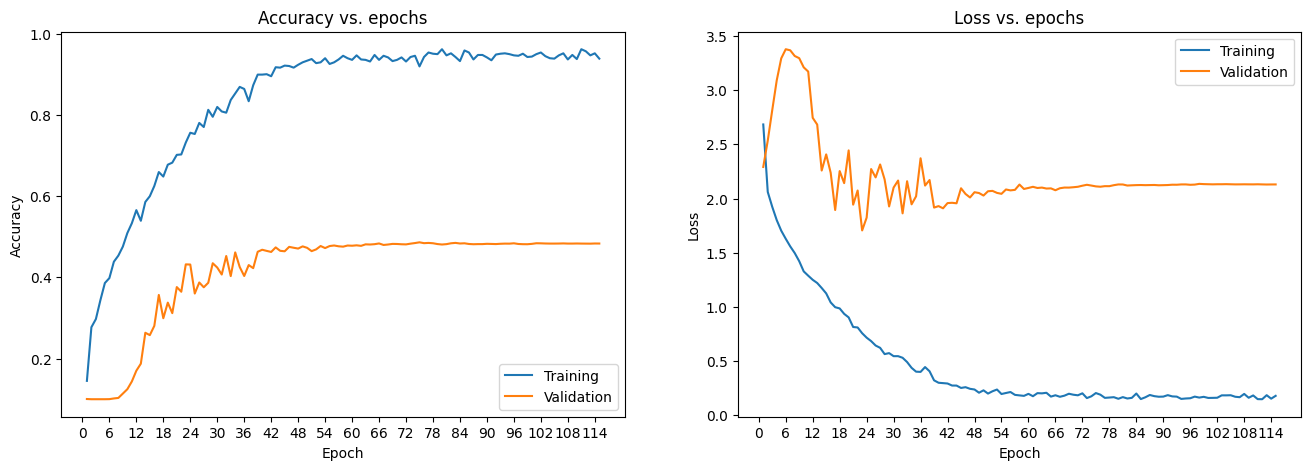

2022-08-09 12:31:07,322: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-09 12:31:12,629: INFO: test loss:2.1118
2022-08-09 12:31:12,629: INFO: test accuracy:0.4863
2022-08-09 12:31:12,631: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json
2022-08-09 12:31:12,633: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json
2022-08-09 12:31:12,633: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:31:12,634: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:31:12,635: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/le

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:31:13,507: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator


313/313 [==============================] - 1s 2ms/step


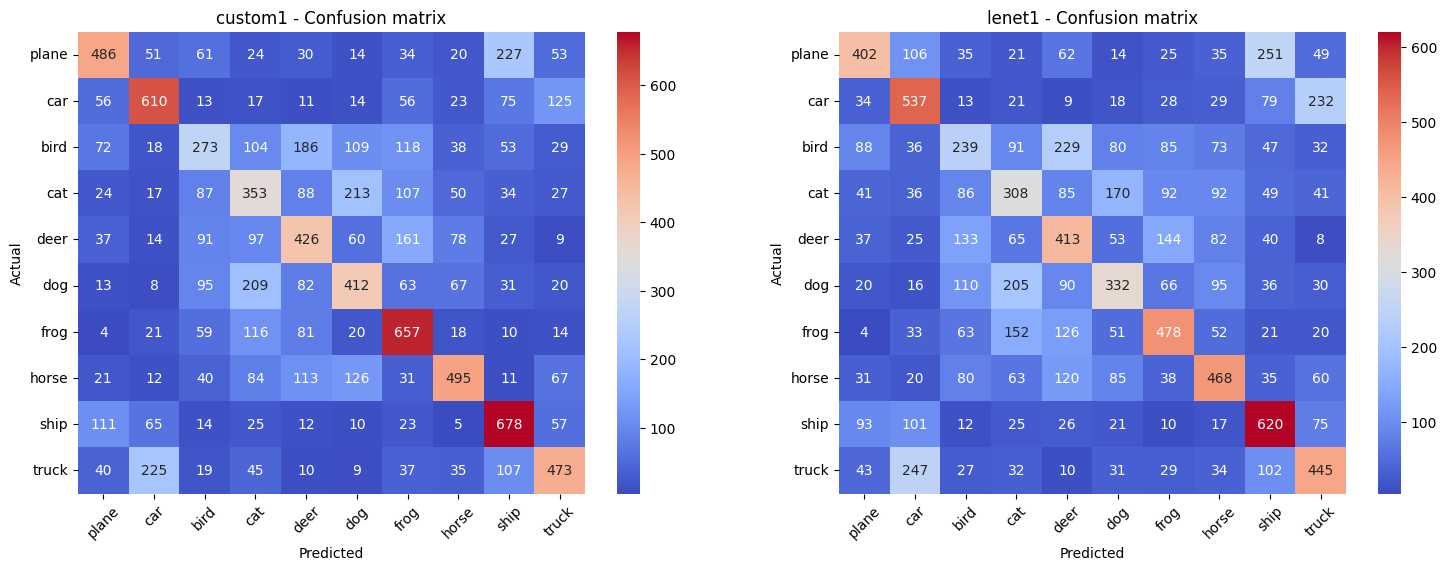

2022-08-09 12:31:18,307: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:31:19,153: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:31:19,155: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1
2022-08-09 12:31:19,461: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:31:19,463: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8
2022-08-09 12:31:21,500: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator


1/1 [==============================] - 0s 10ms/step


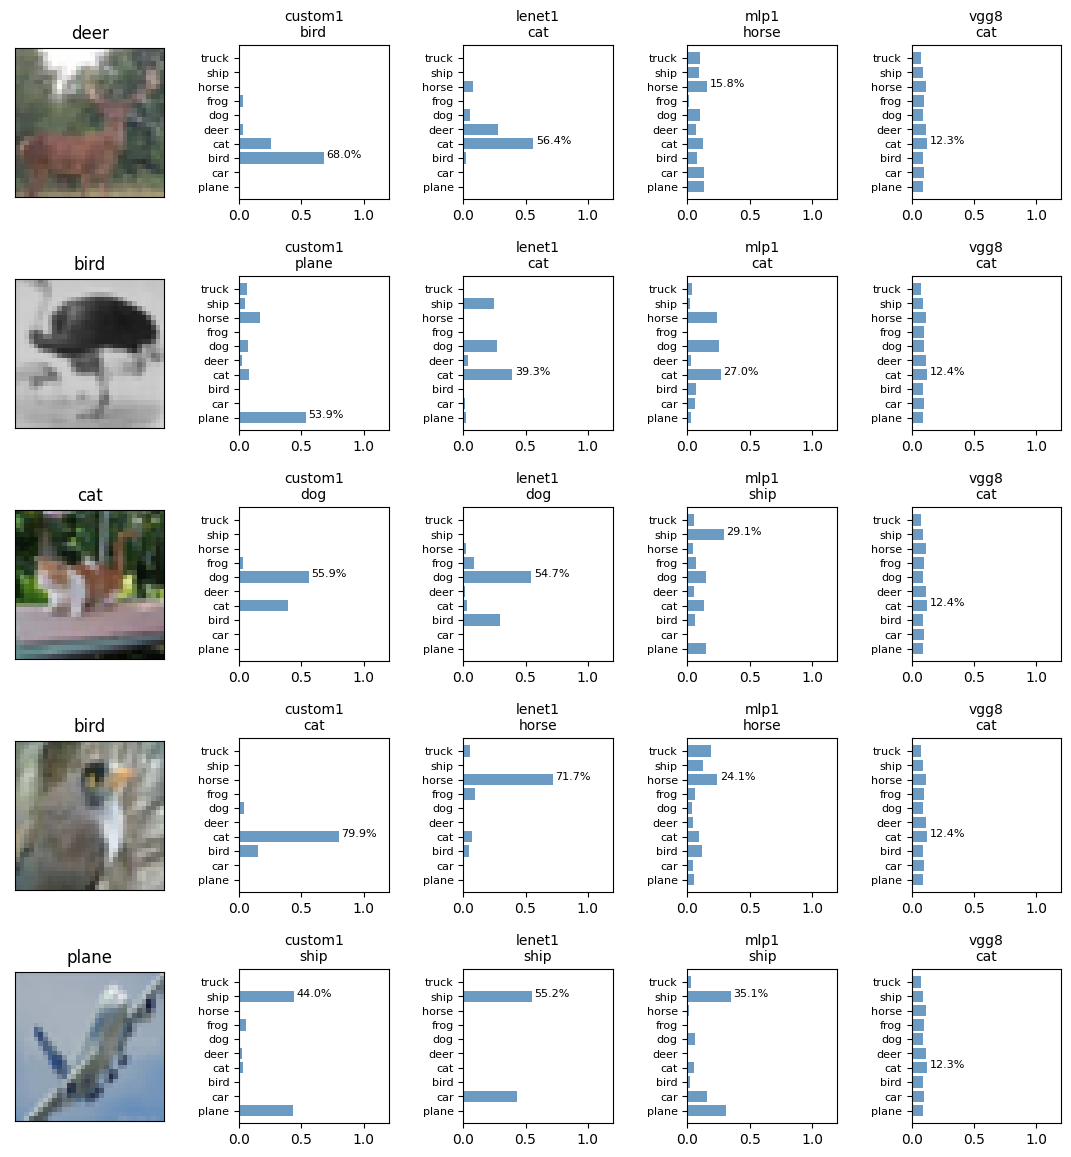

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1    custom1  cifar10_0808_count_100.ipynb          73738       210.6   
2     lenet1  cifar10_0808_count_100.ipynb          83170       156.6   
3       mlp1  cifar10_0808_count_100.ipynb         394634        67.1   
4       vgg8  cifar10_0808_count_100.ipynb        1672906         6.8   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:31      0.0283     2.1118           0.996         0.4863   
2  2022-08-09 12:27      0.0511     2.3820           0.993         0.4242   
3  2022-08-09 12:24      1.2734     2.0015           0.590         0.3229   
4  2022-08-09 05:40      2.3093     2.3088           0.102         0.1000   

   train_auc  test_auc  
1     0.9999    0.8689  
2     1.0000    0.8297  
3     0.9115    0.7675  
4     0.6227    0.6196

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2022-08-09 12:31:26,967: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 12:31:27,145: INFO: learning_rate=0.001
2022-08-09 12:31:27,145: INFO: model_params.vgg8.clip_value=None
2022-08-09 12:31:27,152: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                         

2022-08-09 12:31:27,200: INFO: model_params.vgg8.epochs=120
2022-08-09 12:31:27,201: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8, monitor=val_accuracy)
2022-08-09 12:31:27,202: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:31:27,202: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:31:27,203: INFO: use LearningRateScheduler()
2022-08-09 12:31:27,203: INFO: steps_per_epoch=31
2022-08-09 12:31:27,204: INFO: start training
2022-08-09 12:31:27,205: INFO: use_class_weight=False


Epoch 1/120
29/31 [===========================>..] - ETA: 0s - loss: 2.9193 - accuracy: 0.1379

2022-08-09 12:31:33,120: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:31:34,255: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 7s 195ms/step - loss: 2.8746 - accuracy: 0.1381 - val_loss: 2.2978 - val_accuracy: 0.1001 - lr: 0.0010
Epoch 2/120
31/31 [==============================] - 2s 58ms/step - loss: 2.2290 - accuracy: 0.1683 - val_loss: 2.4353 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/120
31/31 [==============================] - 2s 62ms/step - loss: 2.2080 - accuracy: 0.1774 - val_loss: 2.5447 - val_accuracy: 0.0823 - lr: 0.0010
Epoch 4/120
31/31 [==============================] - 2s 61ms/step - loss: 2.1018 - accuracy: 0.2127 - val_loss: 2.8686 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/120
29/31 [===========================>..] - ETA: 0s - loss: 2.0778 - accuracy: 0.2317

2022-08-09 12:31:44,158: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:31:45,560: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 193ms/step - loss: 2.0776 - accuracy: 0.2319 - val_loss: 2.9641 - val_accuracy: 0.1238 - lr: 0.0010
Epoch 6/120
31/31 [==============================] - 2s 61ms/step - loss: 2.0598 - accuracy: 0.2188 - val_loss: 2.7024 - val_accuracy: 0.1001 - lr: 0.0010
Epoch 7/120
31/31 [==============================] - 2s 53ms/step - loss: 1.9453 - accuracy: 0.2581 - val_loss: 2.7865 - val_accuracy: 0.0998 - lr: 0.0010
Epoch 8/120
31/31 [==============================] - 2s 54ms/step - loss: 1.9166 - accuracy: 0.2732 - val_loss: 3.0175 - val_accuracy: 0.1003 - lr: 0.0010
Epoch 9/120
31/31 [==============================] - 2s 54ms/step - loss: 1.9045 - accuracy: 0.2611 - val_loss: 2.9205 - val_accuracy: 0.1006 - lr: 0.0010
Epoch 10/120
31/31 [==============================] - 2s 53ms/step - loss: 1.8975 - accuracy: 0.2692 - val_loss: 2.5655 - val_accuracy: 0.1014 - lr: 0.0010
Epoch 11/120
31/31 [==============================] - 2s 53ms/step - loss: 1.854

2022-08-09 12:31:59,622: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:32:00,749: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 5s 174ms/step - loss: 1.8412 - accuracy: 0.3024 - val_loss: 2.2305 - val_accuracy: 0.1678 - lr: 0.0010
Epoch 13/120
31/31 [==============================] - 2s 62ms/step - loss: 1.8164 - accuracy: 0.2994 - val_loss: 2.7123 - val_accuracy: 0.1139 - lr: 0.0010
Epoch 14/120
31/31 [==============================] - 2s 63ms/step - loss: 1.8203 - accuracy: 0.2722 - val_loss: 2.4887 - val_accuracy: 0.1383 - lr: 0.0010
Epoch 15/120
29/31 [===========================>..] - ETA: 0s - loss: 1.7740 - accuracy: 0.2909

2022-08-09 12:32:08,821: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:32:10,293: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 189ms/step - loss: 1.7753 - accuracy: 0.2903 - val_loss: 2.5771 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 16/120
31/31 [==============================] - ETA: 0s - loss: 1.7235 - accuracy: 0.3165

2022-08-09 12:32:14,463: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:32:15,612: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 5s 177ms/step - loss: 1.7235 - accuracy: 0.3165 - val_loss: 1.9162 - val_accuracy: 0.2991 - lr: 0.0010
Epoch 17/120
30/31 [============================>.] - ETA: 0s - loss: 1.7048 - accuracy: 0.3531

2022-08-09 12:32:19,828: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:32:21,322: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 190ms/step - loss: 1.7078 - accuracy: 0.3538 - val_loss: 1.7937 - val_accuracy: 0.3361 - lr: 0.0010
Epoch 18/120
31/31 [==============================] - ETA: 0s - loss: 1.6684 - accuracy: 0.3558

2022-08-09 12:32:25,459: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:32:26,512: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 5s 172ms/step - loss: 1.6684 - accuracy: 0.3558 - val_loss: 1.8216 - val_accuracy: 0.3543 - lr: 0.0010
Epoch 19/120
31/31 [==============================] - 2s 51ms/step - loss: 1.7060 - accuracy: 0.3558 - val_loss: 1.7617 - val_accuracy: 0.3468 - lr: 0.0010
Epoch 20/120
27/31 [=========================>....] - ETA: 0s - loss: 1.6575 - accuracy: 0.3553

2022-08-09 12:32:32,225: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:32:33,335: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 5s 175ms/step - loss: 1.6514 - accuracy: 0.3589 - val_loss: 1.7721 - val_accuracy: 0.3603 - lr: 0.0010
Epoch 21/120
31/31 [==============================] - 2s 62ms/step - loss: 1.6100 - accuracy: 0.3700 - val_loss: 1.7961 - val_accuracy: 0.3518 - lr: 0.0010
Epoch 22/120
31/31 [==============================] - 2s 62ms/step - loss: 1.6072 - accuracy: 0.3679 - val_loss: 1.8489 - val_accuracy: 0.3334 - lr: 0.0010
Epoch 23/120
30/31 [============================>.] - ETA: 0s - loss: 1.5329 - accuracy: 0.3854

2022-08-09 12:32:41,888: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:32:43,029: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 197ms/step - loss: 1.5344 - accuracy: 0.3851 - val_loss: 1.7278 - val_accuracy: 0.3777 - lr: 0.0010
Epoch 24/120
31/31 [==============================] - 2s 52ms/step - loss: 1.6081 - accuracy: 0.3679 - val_loss: 2.3412 - val_accuracy: 0.3133 - lr: 0.0010
Epoch 25/120
31/31 [==============================] - 2s 52ms/step - loss: 1.5778 - accuracy: 0.3851 - val_loss: 1.8889 - val_accuracy: 0.3421 - lr: 0.0010
Epoch 26/120
31/31 [==============================] - 2s 54ms/step - loss: 1.5909 - accuracy: 0.3700 - val_loss: 2.0099 - val_accuracy: 0.3647 - lr: 0.0010
Epoch 27/120
31/31 [==============================] - 2s 53ms/step - loss: 1.5516 - accuracy: 0.3800 - val_loss: 1.8054 - val_accuracy: 0.3545 - lr: 0.0010
Epoch 28/120
28/31 [==========================>...] - ETA: 0s - loss: 1.5652 - accuracy: 0.3694

2022-08-09 12:32:53,536: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:32:54,693: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 5s 174ms/step - loss: 1.5523 - accuracy: 0.3760 - val_loss: 1.6079 - val_accuracy: 0.4224 - lr: 0.0010
Epoch 29/120
31/31 [==============================] - 2s 63ms/step - loss: 1.4849 - accuracy: 0.3942 - val_loss: 2.2041 - val_accuracy: 0.3549 - lr: 0.0010
Epoch 30/120
31/31 [==============================] - 2s 57ms/step - loss: 1.4517 - accuracy: 0.4224 - val_loss: 2.3070 - val_accuracy: 0.3387 - lr: 0.0010
Epoch 31/120
31/31 [==============================] - 2s 54ms/step - loss: 1.4630 - accuracy: 0.4194 - val_loss: 1.7789 - val_accuracy: 0.3966 - lr: 0.0010
Epoch 32/120
31/31 [==============================] - 2s 54ms/step - loss: 1.3953 - accuracy: 0.4698 - val_loss: 1.8217 - val_accuracy: 0.3988 - lr: 0.0010
Epoch 33/120
31/31 [==============================] - 2s 55ms/step - loss: 1.4026 - accuracy: 0.4546 - val_loss: 2.0760 - val_accuracy: 0.3330 - lr: 0.0010
Epoch 34/120
31/31 [==============================] - 2s 53ms/step - loss: 1

2022-08-09 12:33:10,905: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:33:12,053: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 186ms/step - loss: 1.3094 - accuracy: 0.4647 - val_loss: 1.6739 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 37/120
31/31 [==============================] - 2s 54ms/step - loss: 1.3157 - accuracy: 0.4889 - val_loss: 2.2618 - val_accuracy: 0.3644 - lr: 0.0010
Epoch 38/120
29/31 [===========================>..] - ETA: 0s - loss: 1.3015 - accuracy: 0.4784

2022-08-09 12:33:17,783: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:33:19,249: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 185ms/step - loss: 1.3045 - accuracy: 0.4808 - val_loss: 1.6488 - val_accuracy: 0.4442 - lr: 0.0010
Epoch 39/120
31/31 [==============================] - 2s 54ms/step - loss: 1.2892 - accuracy: 0.4950 - val_loss: 1.8266 - val_accuracy: 0.3497 - lr: 0.0010
Epoch 40/120
31/31 [==============================] - 2s 54ms/step - loss: 1.2922 - accuracy: 0.5040 - val_loss: 1.7358 - val_accuracy: 0.4216 - lr: 0.0010
Epoch 41/120
31/31 [==============================] - 2s 62ms/step - loss: 1.2321 - accuracy: 0.5151 - val_loss: 1.9548 - val_accuracy: 0.4052 - lr: 0.0010
Epoch 42/120
29/31 [===========================>..] - ETA: 0s - loss: 1.1258 - accuracy: 0.5560

2022-08-09 12:33:28,868: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:33:30,089: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 188ms/step - loss: 1.1544 - accuracy: 0.5393 - val_loss: 1.6784 - val_accuracy: 0.4485 - lr: 0.0010
Epoch 43/120
29/31 [===========================>..] - ETA: 0s - loss: 1.2012 - accuracy: 0.5216
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
31/31 [==============================] - 2s 54ms/step - loss: 1.2014 - accuracy: 0.5181 - val_loss: 2.1313 - val_accuracy: 0.3963 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/120
29/31 [===========================>..] - ETA: 0s - loss: 1.1017 - accuracy: 0.5690

2022-08-09 12:33:35,800: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:33:37,282: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 185ms/step - loss: 1.1186 - accuracy: 0.5645 - val_loss: 1.6648 - val_accuracy: 0.4654 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/120
30/31 [============================>.] - ETA: 0s - loss: 1.1054 - accuracy: 0.5562

2022-08-09 12:33:41,532: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:33:42,679: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 5s 180ms/step - loss: 1.1066 - accuracy: 0.5554 - val_loss: 1.5529 - val_accuracy: 0.4771 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/120
31/31 [==============================] - 2s 63ms/step - loss: 1.0760 - accuracy: 0.5645 - val_loss: 1.6049 - val_accuracy: 0.4764 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/120
31/31 [==============================] - 2s 62ms/step - loss: 1.0520 - accuracy: 0.5736 - val_loss: 1.6338 - val_accuracy: 0.4758 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/120
31/31 [==============================] - 2s 61ms/step - loss: 1.0199 - accuracy: 0.5837 - val_loss: 1.7199 - val_accuracy: 0.4681 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/120
31/31 [==============================] - 2s 63ms/step - loss: 1.0239 - accuracy: 0.5897 - val_loss:

2022-08-09 12:33:56,555: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:33:57,699: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 183ms/step - loss: 1.0128 - accuracy: 0.5786 - val_loss: 1.5666 - val_accuracy: 0.4843 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/120
29/31 [===========================>..] - ETA: 0s - loss: 0.9624 - accuracy: 0.6045

2022-08-09 12:34:02,462: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:34:03,609: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 197ms/step - loss: 0.9733 - accuracy: 0.5968 - val_loss: 1.6409 - val_accuracy: 0.4864 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/120
31/31 [==============================] - 2s 64ms/step - loss: 0.9344 - accuracy: 0.6290 - val_loss: 1.7008 - val_accuracy: 0.4660 - lr: 3.1623e-04
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
Epoch 54/120
31/31 [==============================] - 2s 63ms/step - loss: 0.9090 - accuracy: 0.6341 - val_loss: 1.7105 - val_accuracy: 0.4796 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/120
31/31 [==============================] - 2s 61ms/step - loss: 0.9805 - accuracy: 0.5988 - val_loss: 1.6437 - val_accuracy: 0.4820 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/120
29/31 [===========================>..] - ETA: 0s - loss: 0.9516 - accuracy: 0.6088

2022-08-09 12:34:13,629: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:34:15,074: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 191ms/step - loss: 0.9500 - accuracy: 0.6119 - val_loss: 1.5730 - val_accuracy: 0.4984 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/120
31/31 [==============================] - 2s 63ms/step - loss: 0.9373 - accuracy: 0.6220 - val_loss: 1.7245 - val_accuracy: 0.4766 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/120
31/31 [==============================] - 2s 63ms/step - loss: 0.8815 - accuracy: 0.6411 - val_loss: 1.6763 - val_accuracy: 0.4878 - lr: 3.1623e-04
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 59/120
31/31 [==============================] - 2s 61ms/step - loss: 0.8891 - accuracy: 0.6401 - val_loss: 1.7504 - val_accuracy: 0.4903 - lr: 3.1623e-04
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
Epoch 60/120
29/31 [===========================>..] - ETA: 0s - loss: 0.8952 - accuracy: 0.6315
Epoch 60: Reduce

2022-08-09 12:34:26,847: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:34:27,994: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 5s 181ms/step - loss: 0.8788 - accuracy: 0.6401 - val_loss: 1.6321 - val_accuracy: 0.5022 - lr: 1.0000e-04
Epoch 62/120
29/31 [===========================>..] - ETA: 0s - loss: 0.8427 - accuracy: 0.6573

2022-08-09 12:34:32,205: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:34:33,721: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 190ms/step - loss: 0.8442 - accuracy: 0.6583 - val_loss: 1.6289 - val_accuracy: 0.5050 - lr: 1.0000e-04
Epoch 63/120
31/31 [==============================] - 2s 59ms/step - loss: 0.8295 - accuracy: 0.6593 - val_loss: 1.6572 - val_accuracy: 0.5012 - lr: 1.0000e-04
Epoch 64/120
31/31 [==============================] - 2s 56ms/step - loss: 0.8479 - accuracy: 0.6371 - val_loss: 1.7023 - val_accuracy: 0.4987 - lr: 1.0000e-04
Epoch 65/120
29/31 [===========================>..] - ETA: 0s - loss: 0.8525 - accuracy: 0.6562

2022-08-09 12:34:41,482: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:34:42,616: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 5s 180ms/step - loss: 0.8420 - accuracy: 0.6613 - val_loss: 1.6561 - val_accuracy: 0.5069 - lr: 1.0000e-04
Epoch 66/120
31/31 [==============================] - 2s 59ms/step - loss: 0.7766 - accuracy: 0.6925 - val_loss: 1.7708 - val_accuracy: 0.4982 - lr: 1.0000e-04
Epoch 67/120
31/31 [==============================] - 2s 59ms/step - loss: 0.8294 - accuracy: 0.6613 - val_loss: 1.7729 - val_accuracy: 0.4981 - lr: 1.0000e-04
Epoch 68/120
31/31 [==============================] - 2s 56ms/step - loss: 0.8061 - accuracy: 0.6754 - val_loss: 1.7728 - val_accuracy: 0.4955 - lr: 1.0000e-04
Epoch 69/120
31/31 [==============================] - 2s 58ms/step - loss: 0.7963 - accuracy: 0.6804 - val_loss: 1.7712 - val_accuracy: 0.4976 - lr: 1.0000e-04
Epoch 70/120
31/31 [==============================] - 2s 57ms/step - loss: 0.8414 - accuracy: 0.6583 - val_loss: 1.7209 - val_accuracy: 0.4973 - lr: 1.0000e-04
Epoch 71/120
31/31 [==============================] 

2022-08-09 12:35:10,831: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:35:12,341: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 190ms/step - loss: 0.7872 - accuracy: 0.6673 - val_loss: 1.7270 - val_accuracy: 0.5087 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/120
31/31 [==============================] - 2s 70ms/step - loss: 0.7861 - accuracy: 0.6784 - val_loss: 1.7253 - val_accuracy: 0.5074 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/120
31/31 [==============================] - 2s 58ms/step - loss: 0.7651 - accuracy: 0.7016 - val_loss: 1.7217 - val_accuracy: 0.5079 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
29/31 [===========================>..] - ETA: 0s - loss: 0.7459 - accuracy: 0.7047

2022-08-09 12:35:20,741: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:35:21,878: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 187ms/step - loss: 0.7469 - accuracy: 0.7036 - val_loss: 1.7199 - val_accuracy: 0.5100 - lr: 3.1623e-05
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 82/120
31/31 [==============================] - 2s 58ms/step - loss: 0.7748 - accuracy: 0.6895 - val_loss: 1.7439 - val_accuracy: 0.5062 - lr: 3.1623e-05
Epoch 00083: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 83/120
31/31 [==============================] - 2s 61ms/step - loss: 0.7864 - accuracy: 0.6804 - val_loss: 1.7634 - val_accuracy: 0.5085 - lr: 3.1623e-05
Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 84/120
31/31 [==============================] - 3s 83ms/step - loss: 0.7915 - accuracy: 0.6562 - val_loss: 1.7730 - val_accuracy: 0.5067 - lr: 3.1623e-05
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/120
31/31 [==============================] - 2s 81ms/step - loss: 0.7593 - accuracy: 0.6946 - val_loss:

2022-08-09 12:35:51,986: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:35:53,099: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 190ms/step - loss: 0.7018 - accuracy: 0.7147 - val_loss: 1.7538 - val_accuracy: 0.5101 - lr: 1.0000e-05
Epoch 95/120
31/31 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.6966

2022-08-09 12:35:58,430: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:35:59,582: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 215ms/step - loss: 0.7332 - accuracy: 0.6966 - val_loss: 1.7514 - val_accuracy: 0.5113 - lr: 1.0000e-05
Epoch 96/120
31/31 [==============================] - 2s 80ms/step - loss: 0.7482 - accuracy: 0.6804 - val_loss: 1.7498 - val_accuracy: 0.5109 - lr: 1.0000e-05
Epoch 97/120
31/31 [==============================] - 3s 84ms/step - loss: 0.7409 - accuracy: 0.7006 - val_loss: 1.7520 - val_accuracy: 0.5096 - lr: 1.0000e-05
Epoch 98/120
31/31 [==============================] - 2s 59ms/step - loss: 0.7690 - accuracy: 0.6905 - val_loss: 1.7504 - val_accuracy: 0.5096 - lr: 1.0000e-05
Epoch 99/120
30/31 [============================>.] - ETA: 0s - loss: 0.7595 - accuracy: 0.6823

2022-08-09 12:36:10,530: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


2022-08-09 12:36:12,038: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8/assets


31/31 [==============================] - 6s 190ms/step - loss: 0.7639 - accuracy: 0.6784 - val_loss: 1.7530 - val_accuracy: 0.5117 - lr: 1.0000e-05
Epoch 100/120
31/31 [==============================] - 2s 82ms/step - loss: 0.7004 - accuracy: 0.7097 - val_loss: 1.7570 - val_accuracy: 0.5106 - lr: 1.0000e-05
Epoch 101/120
31/31 [==============================] - 3s 84ms/step - loss: 0.7612 - accuracy: 0.6885 - val_loss: 1.7665 - val_accuracy: 0.5108 - lr: 1.0000e-05
Epoch 102/120
31/31 [==============================] - 2s 79ms/step - loss: 0.7410 - accuracy: 0.6976 - val_loss: 1.7746 - val_accuracy: 0.5087 - lr: 1.0000e-05
Epoch 103/120
31/31 [==============================] - 2s 81ms/step - loss: 0.7186 - accuracy: 0.7026 - val_loss: 1.7678 - val_accuracy: 0.5085 - lr: 1.0000e-05
Epoch 104/120
31/31 [==============================] - 2s 79ms/step - loss: 0.7211 - accuracy: 0.7067 - val_loss: 1.7765 - val_accuracy: 0.5093 - lr: 1.0000e-05
Epoch 105/120
31/31 [==========================

2022-08-09 12:36:57,028: INFO: finish training [elapsed time: 329.82 seconds]


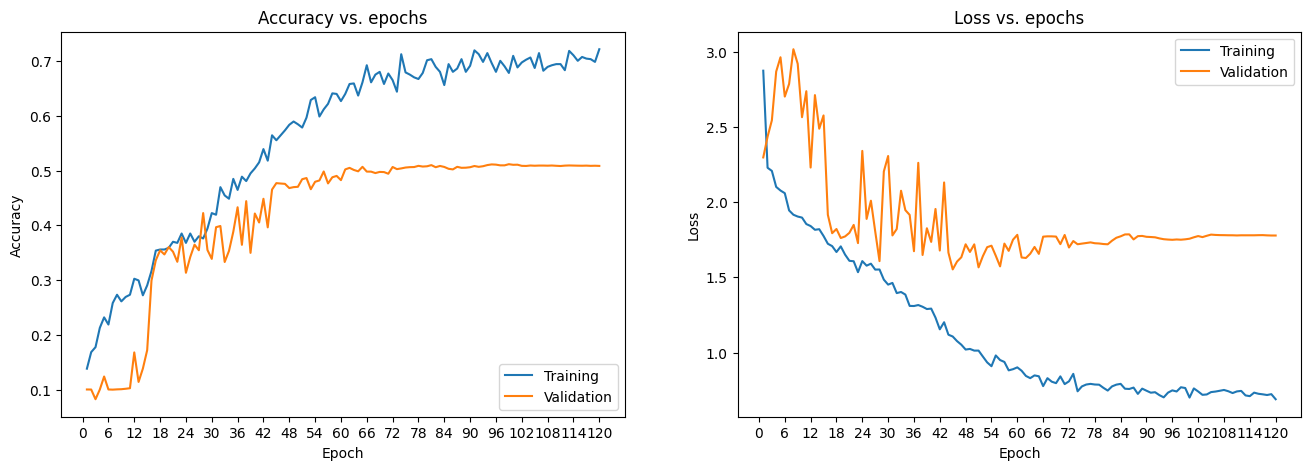

2022-08-09 12:36:57,469: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-09 12:37:04,082: INFO: test loss:1.7530
2022-08-09 12:37:04,083: INFO: test accuracy:0.5117
2022-08-09 12:37:04,085: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json
2022-08-09 12:37:04,087: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json
2022-08-09 12:37:04,087: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:37:04,088: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:37:04,089: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/cu

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:37:05,068: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator


313/313 [==============================] - 1s 3ms/step


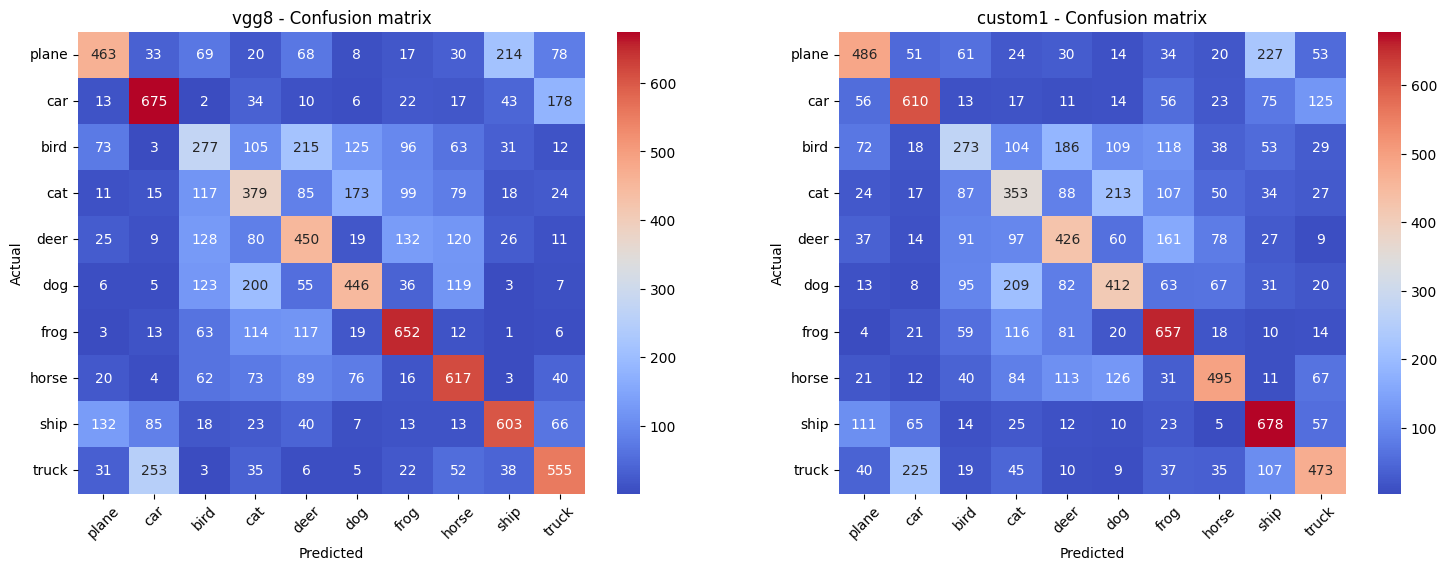

2022-08-09 12:37:10,545: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:37:12,040: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:37:12,042: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1
2022-08-09 12:37:12,923: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:37:12,926: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/mlp1
2022-08-09 12:37:13,236: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator


1/1 [==============================] - 0s 10ms/step


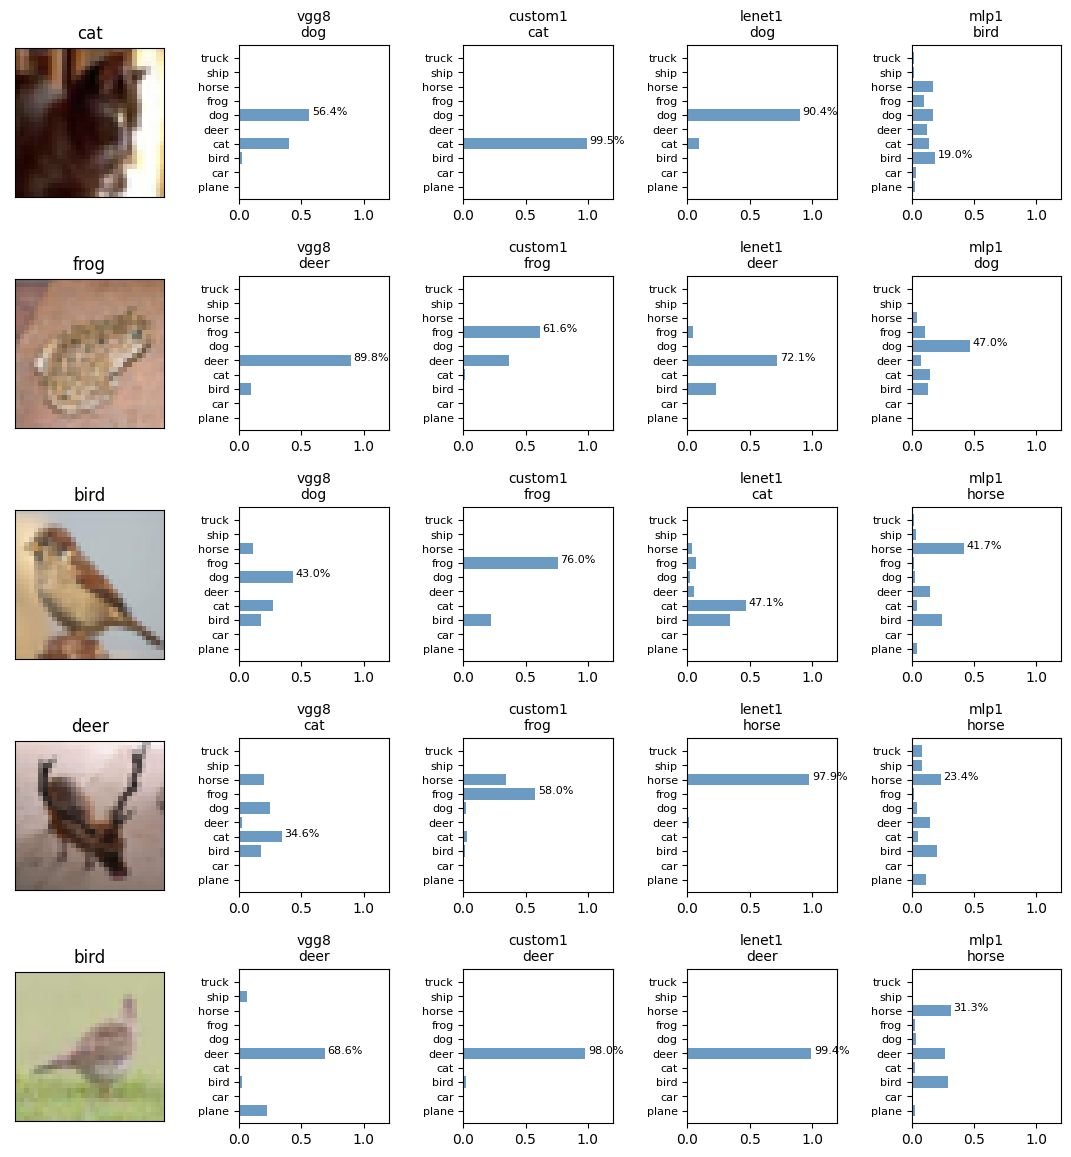

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1       vgg8  cifar10_0808_count_100.ipynb        1672906       329.8   
2    custom1  cifar10_0808_count_100.ipynb          73738       210.6   
3     lenet1  cifar10_0808_count_100.ipynb          83170       156.6   
4       mlp1  cifar10_0808_count_100.ipynb         394634        67.1   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:37      0.3215     1.7530           0.928         0.5117   
2  2022-08-09 12:31      0.0283     2.1118           0.996         0.4863   
3  2022-08-09 12:27      0.0511     2.3820           0.993         0.4242   
4  2022-08-09 12:24      1.2734     2.0015           0.590         0.3229   

   train_auc  test_auc  
1     0.9969    0.8844  
2     0.9999    0.8689  
3     1.0000    0.8297  
4     0.9115    0.7675

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 12:37:19,972: INFO: learning_rate=0.001
2022-08-09 12:37:19,973: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-09 12:37:19,983: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization_

                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_15 (BatchN  (None, 16, 16, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (Dense)                (None, 10)           650         ['flatten_4[0][0]']              
                                                                                                  
Total para

2022-08-09 12:37:20,116: INFO: model_params.resnet_v1_20.epochs=80
2022-08-09 12:37:20,117: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20, monitor=val_accuracy)
2022-08-09 12:37:20,117: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:37:20,118: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:37:20,119: INFO: use LearningRateScheduler()
2022-08-09 12:37:20,119: INFO: steps_per_epoch=31
2022-08-09 12:37:20,120: INFO: start training
2022-08-09 12:37:20,120: INFO: use_class_weight=False


Epoch 1/80
31/31 [==============================] - ETA: 0s - loss: 2.4537 - accuracy: 0.2238

2022-08-09 12:37:34,314: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:37:37,333: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 17s 474ms/step - loss: 2.4537 - accuracy: 0.2238 - val_loss: 2.4652 - val_accuracy: 0.1224 - lr: 0.0010
Epoch 2/80
29/31 [===========================>..] - ETA: 0s - loss: 1.8234 - accuracy: 0.4009

2022-08-09 12:37:47,033: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:37:50,268: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 13s 430ms/step - loss: 1.8231 - accuracy: 0.4012 - val_loss: 2.4434 - val_accuracy: 0.1534 - lr: 0.0010
Epoch 3/80
31/31 [==============================] - 3s 83ms/step - loss: 1.4644 - accuracy: 0.5685 - val_loss: 2.8440 - val_accuracy: 0.1521 - lr: 0.0010
Epoch 4/80
31/31 [==============================] - 3s 103ms/step - loss: 1.1341 - accuracy: 0.7046 - val_loss: 4.4583 - val_accuracy: 0.1186 - lr: 0.0010
Epoch 5/80
31/31 [==============================] - 3s 104ms/step - loss: 0.8525 - accuracy: 0.7883 - val_loss: 5.3703 - val_accuracy: 0.1203 - lr: 0.0010
Epoch 6/80
29/31 [===========================>..] - ETA: 0s - loss: 0.7199 - accuracy: 0.8470

2022-08-09 12:38:08,858: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:38:11,886: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 13s 428ms/step - loss: 0.7298 - accuracy: 0.8387 - val_loss: 3.5165 - val_accuracy: 0.2495 - lr: 0.0010
Epoch 7/80
31/31 [==============================] - 3s 103ms/step - loss: 0.7191 - accuracy: 0.8165 - val_loss: 4.1837 - val_accuracy: 0.2124 - lr: 0.0010
Epoch 8/80
31/31 [==============================] - 3s 98ms/step - loss: 0.5800 - accuracy: 0.8659 - val_loss: 4.6600 - val_accuracy: 0.2103 - lr: 0.0010
Epoch 9/80
31/31 [==============================] - ETA: 0s - loss: 0.4241 - accuracy: 0.9315

2022-08-09 12:38:28,045: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:38:31,046: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 13s 433ms/step - loss: 0.4241 - accuracy: 0.9315 - val_loss: 3.5870 - val_accuracy: 0.3006 - lr: 0.0010
Epoch 10/80
31/31 [==============================] - 3s 89ms/step - loss: 0.3006 - accuracy: 0.9738 - val_loss: 4.4786 - val_accuracy: 0.2475 - lr: 0.0010
Epoch 11/80
31/31 [==============================] - 3s 93ms/step - loss: 0.2336 - accuracy: 0.9879 - val_loss: 4.6989 - val_accuracy: 0.2387 - lr: 0.0010
Epoch 12/80
31/31 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9990

2022-08-09 12:38:46,983: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:38:50,275: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 455ms/step - loss: 0.1819 - accuracy: 0.9990 - val_loss: 3.1401 - val_accuracy: 0.3208 - lr: 0.0010
Epoch 13/80
28/31 [==========================>...] - ETA: 0s - loss: 0.1696 - accuracy: 1.0000

2022-08-09 12:38:59,555: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:39:03,202: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 13s 431ms/step - loss: 0.1693 - accuracy: 1.0000 - val_loss: 2.9407 - val_accuracy: 0.3391 - lr: 0.0010
Epoch 14/80
29/31 [===========================>..] - ETA: 0s - loss: 0.1660 - accuracy: 1.0000

2022-08-09 12:39:13,040: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:39:16,481: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 13s 441ms/step - loss: 0.1660 - accuracy: 1.0000 - val_loss: 2.8551 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 15/80
31/31 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 1.0000

2022-08-09 12:39:27,674: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:39:30,846: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 478ms/step - loss: 0.1646 - accuracy: 1.0000 - val_loss: 2.7926 - val_accuracy: 0.3469 - lr: 0.0010
Epoch 16/80
31/31 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 1.0000

2022-08-09 12:39:42,103: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:39:45,217: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 15s 482ms/step - loss: 0.1636 - accuracy: 1.0000 - val_loss: 2.7583 - val_accuracy: 0.3518 - lr: 0.0010
Epoch 17/80
29/31 [===========================>..] - ETA: 0s - loss: 0.1628 - accuracy: 1.0000

2022-08-09 12:39:55,900: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:39:59,249: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
31/31 [==============================] - 14s 461ms/step - loss: 0.1627 - accuracy: 1.0000 - val_loss: 2.7399 - val_accuracy: 0.3527 - lr: 3.1623e-04
Epoch 00018: Still keep learning rate 0.0003162 instead of 0.001
Epoch 18/80
31/31 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 1.0000

2022-08-09 12:40:09,813: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:40:12,983: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 457ms/step - loss: 0.1621 - accuracy: 1.0000 - val_loss: 2.7250 - val_accuracy: 0.3538 - lr: 3.1623e-04
Epoch 00019: Still keep learning rate 0.0003162 instead of 0.001
Epoch 19/80
31/31 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 1.0000

2022-08-09 12:40:23,937: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:40:27,005: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 465ms/step - loss: 0.1619 - accuracy: 1.0000 - val_loss: 2.7186 - val_accuracy: 0.3554 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/80
31/31 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 1.0000

2022-08-09 12:40:37,672: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:40:40,859: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 460ms/step - loss: 0.1616 - accuracy: 1.0000 - val_loss: 2.7167 - val_accuracy: 0.3575 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/80
31/31 [==============================] - 3s 113ms/step - loss: 0.1614 - accuracy: 1.0000 - val_loss: 2.7170 - val_accuracy: 0.3566 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/80
31/31 [==============================] - 3s 91ms/step - loss: 0.1611 - accuracy: 1.0000 - val_loss: 2.7183 - val_accuracy: 0.3572 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/80
31/31 [==============================] - 3s 111ms/step - loss: 0.1608 - accuracy: 1.0000 - val_loss: 2.7202 - val_accuracy: 0.3569 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/80
31/31 [==============================] - 3s 90ms/step - loss: 0.1606 - accuracy: 1.0000 - val_loss: 

2022-08-09 12:41:04,022: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:41:07,109: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 466ms/step - loss: 0.1603 - accuracy: 1.0000 - val_loss: 2.7248 - val_accuracy: 0.3581 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/80
30/31 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 1.0000

2022-08-09 12:41:17,635: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:41:20,727: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 452ms/step - loss: 0.1600 - accuracy: 1.0000 - val_loss: 2.7274 - val_accuracy: 0.3582 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/80
31/31 [==============================] - 3s 103ms/step - loss: 0.1598 - accuracy: 1.0000 - val_loss: 2.7299 - val_accuracy: 0.3575 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/80
31/31 [==============================] - 3s 97ms/step - loss: 0.1595 - accuracy: 1.0000 - val_loss: 2.7322 - val_accuracy: 0.3580 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/80
31/31 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 1.0000

2022-08-09 12:41:37,172: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:41:40,256: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 13s 448ms/step - loss: 0.1592 - accuracy: 1.0000 - val_loss: 2.7346 - val_accuracy: 0.3583 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/80
31/31 [==============================] - 3s 104ms/step - loss: 0.1589 - accuracy: 1.0000 - val_loss: 2.7370 - val_accuracy: 0.3583 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/80
31/31 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 1.0000

2022-08-09 12:41:54,041: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:41:57,109: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 455ms/step - loss: 0.1586 - accuracy: 1.0000 - val_loss: 2.7394 - val_accuracy: 0.3587 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/80
31/31 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 1.0000

2022-08-09 12:42:07,590: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:42:10,851: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
31/31 [==============================] - 14s 459ms/step - loss: 0.1583 - accuracy: 1.0000 - val_loss: 2.7418 - val_accuracy: 0.3590 - lr: 1.0000e-04
Epoch 00033: Still keep learning rate 0.0001 instead of 0.001
Epoch 33/80
29/31 [===========================>..] - ETA: 0s - loss: 0.1581 - accuracy: 1.0000

2022-08-09 12:42:21,551: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:42:24,672: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 458ms/step - loss: 0.1581 - accuracy: 1.0000 - val_loss: 2.7448 - val_accuracy: 0.3597 - lr: 1.0000e-04
Epoch 00034: Still keep learning rate 0.0001 instead of 0.001
Epoch 34/80
30/31 [============================>.] - ETA: 0s - loss: 0.1580 - accuracy: 1.0000

2022-08-09 12:42:35,695: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:42:38,805: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 470ms/step - loss: 0.1580 - accuracy: 1.0000 - val_loss: 2.7473 - val_accuracy: 0.3600 - lr: 1.0000e-04
Epoch 00035: Still keep learning rate 0.0001 instead of 0.001
Epoch 35/80
31/31 [==============================] - 3s 111ms/step - loss: 0.1580 - accuracy: 1.0000 - val_loss: 2.7494 - val_accuracy: 0.3597 - lr: 1.0000e-04
Epoch 00036: Still keep learning rate 0.0001 instead of 0.001
Epoch 36/80
31/31 [==============================] - 3s 107ms/step - loss: 0.1579 - accuracy: 1.0000 - val_loss: 2.7512 - val_accuracy: 0.3598 - lr: 1.0000e-04
Epoch 00037: Still keep learning rate 0.0001 instead of 0.001
Epoch 37/80
31/31 [==============================] - 3s 105ms/step - loss: 0.1578 - accuracy: 1.0000 - val_loss: 2.7527 - val_accuracy: 0.3598 - lr: 1.0000e-04
Epoch 00038: Still keep learning rate 0.0001 instead of 0.001
Epoch 38/80
31/31 [==============================] - 3s 108ms/step - loss: 0.1577 - accuracy: 1.0000 - val_loss: 2.7541 - v

2022-08-09 12:43:02,034: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:43:05,087: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 13s 439ms/step - loss: 0.1575 - accuracy: 1.0000 - val_loss: 2.7553 - val_accuracy: 0.3601 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/80
31/31 [==============================] - 3s 93ms/step - loss: 0.1574 - accuracy: 1.0000 - val_loss: 2.7564 - val_accuracy: 0.3598 - lr: 1.0000e-04
Epoch 00041: Still keep learning rate 0.0001 instead of 0.001
Epoch 41/80
31/31 [==============================] - 3s 94ms/step - loss: 0.1573 - accuracy: 1.0000 - val_loss: 2.7575 - val_accuracy: 0.3596 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/80
31/31 [==============================] - 3s 100ms/step - loss: 0.1572 - accuracy: 1.0000 - val_loss: 2.7585 - val_accuracy: 0.3597 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/80
31/31 [==============================] - 3s 90ms/step - loss: 0.1571 - accuracy: 1.0000 - val_loss: 2.7594 - val_

2022-08-09 12:44:05,202: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:44:08,285: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 468ms/step - loss: 0.1466 - accuracy: 1.0000 - val_loss: 2.7797 - val_accuracy: 0.3603 - lr: 0.0010
Epoch 57/80
30/31 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 1.0000

2022-08-09 12:44:18,973: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:44:22,314: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 466ms/step - loss: 0.1454 - accuracy: 1.0000 - val_loss: 2.7832 - val_accuracy: 0.3605 - lr: 0.0010
Epoch 58/80
31/31 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 1.0000

2022-08-09 12:44:33,285: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:44:36,427: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 470ms/step - loss: 0.1442 - accuracy: 1.0000 - val_loss: 2.7865 - val_accuracy: 0.3612 - lr: 0.0010
Epoch 59/80
31/31 [==============================] - 3s 111ms/step - loss: 0.1431 - accuracy: 1.0000 - val_loss: 2.7898 - val_accuracy: 0.3609 - lr: 0.0010
Epoch 60/80
31/31 [==============================] - 3s 113ms/step - loss: 0.1419 - accuracy: 1.0000 - val_loss: 2.7930 - val_accuracy: 0.3607 - lr: 0.0010
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
Epoch 61/80
31/31 [==============================] - 3s 113ms/step - loss: 0.1412 - accuracy: 1.0000 - val_loss: 2.8064 - val_accuracy: 0.3605 - lr: 1.0000e-04
Epoch 62/80
31/31 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 1.0000
Epoch 62: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
31/31 [==============================] - 3s 105ms/step - loss: 0.1411 - accuracy: 1.0000 - val_loss: 2.8190 - val_accuracy: 0.3603

2022-08-09 12:45:26,356: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:45:29,582: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 471ms/step - loss: 0.1407 - accuracy: 1.0000 - val_loss: 2.8703 - val_accuracy: 0.3613 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/80
31/31 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 1.0000

2022-08-09 12:45:40,568: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:45:43,927: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 474ms/step - loss: 0.1407 - accuracy: 1.0000 - val_loss: 2.8715 - val_accuracy: 0.3614 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/80
31/31 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 1.0000

2022-08-09 12:45:53,960: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:45:57,636: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 457ms/step - loss: 0.1406 - accuracy: 1.0000 - val_loss: 2.8724 - val_accuracy: 0.3615 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/80
30/31 [============================>.] - ETA: 0s - loss: 0.1406 - accuracy: 1.0000

2022-08-09 12:46:08,418: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:46:11,477: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 459ms/step - loss: 0.1406 - accuracy: 1.0000 - val_loss: 2.8731 - val_accuracy: 0.3616 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/80
30/31 [============================>.] - ETA: 0s - loss: 0.1405 - accuracy: 1.0000

2022-08-09 12:46:21,918: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:46:25,066: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 452ms/step - loss: 0.1405 - accuracy: 1.0000 - val_loss: 2.8737 - val_accuracy: 0.3617 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/80
31/31 [==============================] - 3s 89ms/step - loss: 0.1405 - accuracy: 1.0000 - val_loss: 2.8742 - val_accuracy: 0.3617 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/80
31/31 [==============================] - ETA: 0s - loss: 0.1404 - accuracy: 1.0000
Epoch 77: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
31/31 [==============================] - 3s 94ms/step - loss: 0.1404 - accuracy: 1.0000 - val_loss: 2.8745 - val_accuracy: 0.3617 - lr: 1.0000e-05
Epoch 00078: Still keep learning rate 1e-05 instead of 0.0001
Epoch 78/80
31/31 [==============================] - 3s 94ms/step - loss: 0.1404 - accuracy: 1.0000 - val_loss: 2.8757 - val_accuracy: 0.3615 - lr: 1.0000e-05
Epoch 00079: Still kee

2022-08-09 12:46:46,815: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


2022-08-09 12:46:50,216: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20/assets


31/31 [==============================] - 14s 462ms/step - loss: 0.1404 - accuracy: 1.0000 - val_loss: 2.8772 - val_accuracy: 0.3618 - lr: 1.0000e-05


2022-08-09 12:46:50,589: INFO: finish training [elapsed time: 570.47 seconds]


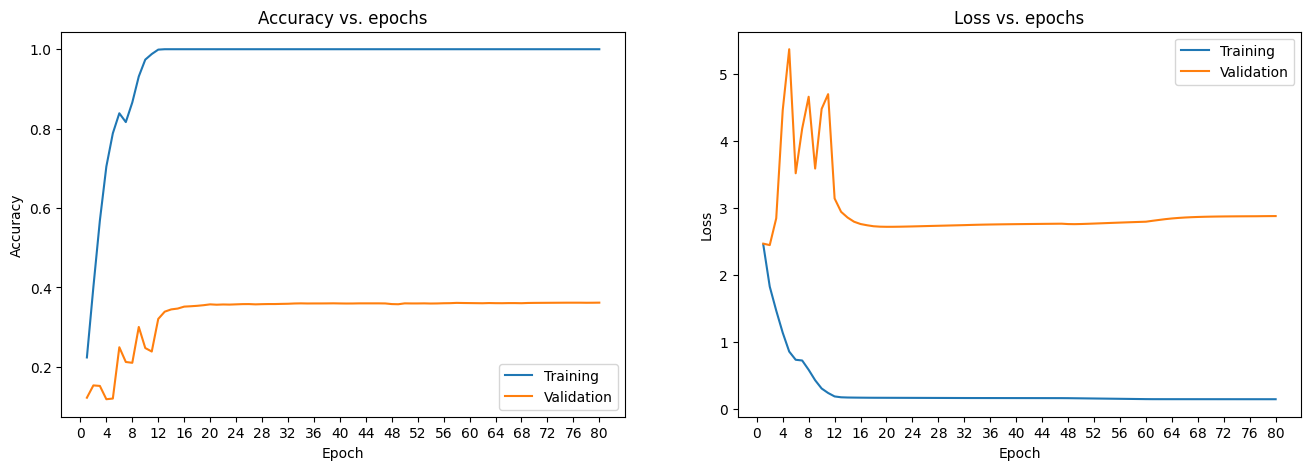

2022-08-09 12:46:51,047: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-09 12:47:03,964: INFO: test loss:2.8772
2022-08-09 12:47:03,965: INFO: test accuracy:0.3618
2022-08-09 12:47:03,970: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json
2022-08-09 12:47:03,971: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/results.json
2022-08-09 12:47:03,972: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:47:03,973: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:47:03,974: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vg

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:47:05,638: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator


313/313 [==============================] - 1s 3ms/step


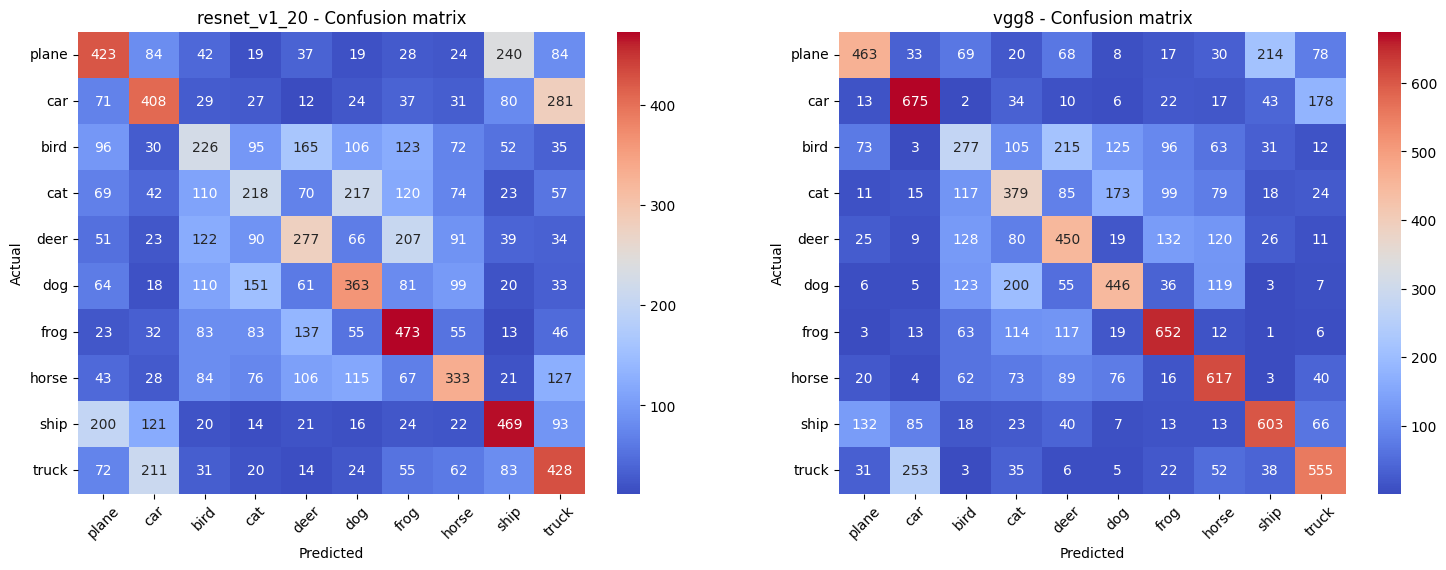

2022-08-09 12:47:12,136: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/vgg8


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:47:13,752: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:47:13,760: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/custom1
2022-08-09 12:47:14,761: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:47:14,764: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/lenet1
2022-08-09 12:47:16,188: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_100/default.generator
2022-08-09 12:47:16,191: INFO: loading model from /tf/eipi10/xuxiangwen.github.

1/1 [==============================] - 0s 124ms/step


2022-08-09 12:47:20,339: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fc6f80821f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 9ms/step


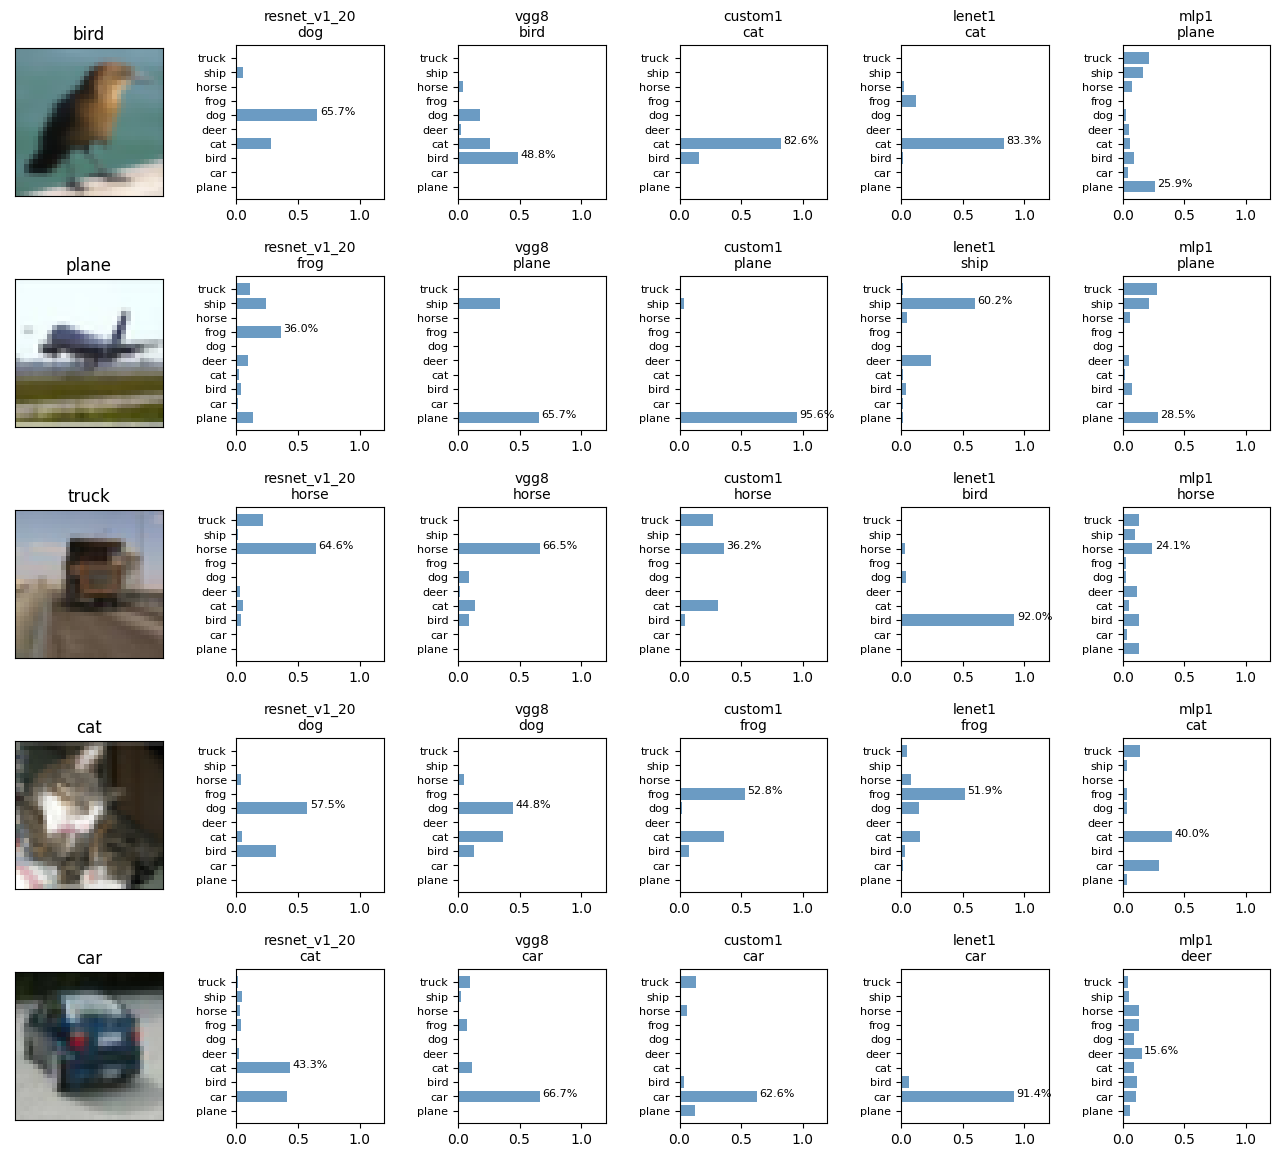

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_count_100.ipynb        1672906       329.8   
2       custom1  cifar10_0808_count_100.ipynb          73738       210.6   
3        lenet1  cifar10_0808_count_100.ipynb          83170       156.6   
4  resnet_v1_20  cifar10_0808_count_100.ipynb         273066       570.5   
5          mlp1  cifar10_0808_count_100.ipynb         394634        67.1   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:37      0.3215     1.7530           0.928         0.5117   
2  2022-08-09 12:31      0.0283     2.1118           0.996         0.4863   
3  2022-08-09 12:27      0.0511     2.3820           0.993         0.4242   
4  2022-08-09 12:47      0.1602     2.8772           0.995         0.3618   
5  2022-08-09 12:24      1.2734     2.0015           0.590         0.3229   

   train_auc  test_auc  
1     0.9969    0.8844  
2     0.9999    0.8689  
3     1.0000    0.8297  
4     1.0000    0.7814  
5     0.9115    0.7675

In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [26]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-09 12:47:24,475: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-09 12:47:24,477: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2022-08-09 12:47:24,478: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 12:47:24,480: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 12:47:24,481: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 12:47:24,482: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflo

model_name                   program_name  weight_number  train_time  \
1           vgg8        cifar10_0808_p100.ipynb        1672906      2759.0   
2           vgg8        cifar10_0721_p100.ipynb        1672906      2195.2   
3           vgg8  cifar10_0808_count_5000.ipynb        1672906      1973.9   
4           vgg8  cifar10_0808_count_2000.ipynb        1672906      1399.2   
5   resnet_v1_20        cifar10_0808_p100.ipynb         273066      3631.9   
6   resnet_v1_20  cifar10_0808_count_5000.ipynb         273066      2984.0   
7   resnet_v1_20        cifar10_0721_p100.ipynb         273066      4091.3   
8        custom1        cifar10_0808_p100.ipynb          73738       849.4   
9        custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
10       custom1        cifar10_0721_p100.ipynb          73738      1190.8   

         create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1   2022-08-09 10:18      0.0017     0.5896          0.9997         0.8968   
2   2021-12-02 08:49      0.0029     0.5959          0.9995         0.8921   
3   2022-08-09 07:07      0.0044     0.5588          0.9991         0.8873   
4   2022-08-09 10:22      0.0064     0.8481          0.9987         0.8418   
5   2022-08-09 11:19      0.1058     1.3800          0.9979         0.8262   
6   2022-08-09 07:58      0.2096     1.1902          0.9986         0.8252   
7   2021-12-02 09:58      0.1180     1.3054          0.9985         0.8197   
8   2022-08-09 09:31      0.3383     0.5942          0.8858         0.8009   
9   2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
10  2021-12-02 08:12      0.3420     0.6094          0.8832         0.7947   

    train_auc  test_auc  
1      1.0000    0.9922  
2      1.0000    0.9920  
3      1.0000    0.9919  
4      1.0000    0.9838  
5      1.0000    0.9796  
6      1.0000    0.9810  
7      1.0000    0.9791  
8      0.9926    0.9778  
9      0.9934    0.9776  
10     0.9929    0.9776

In [27]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-09 12:47:24,567: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8
2022-08-09 12:47:26,554: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 12:47:26,559: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
2022-08-09 12:47:29,070: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2022-08-09 12:47:29,079: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8
2022-08-09 12:47:30,859: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_c

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 0s 179ms/step


2022-08-09 12:47:38,470: WARNING: 5 out of the last 25 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fc630345550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 14ms/step


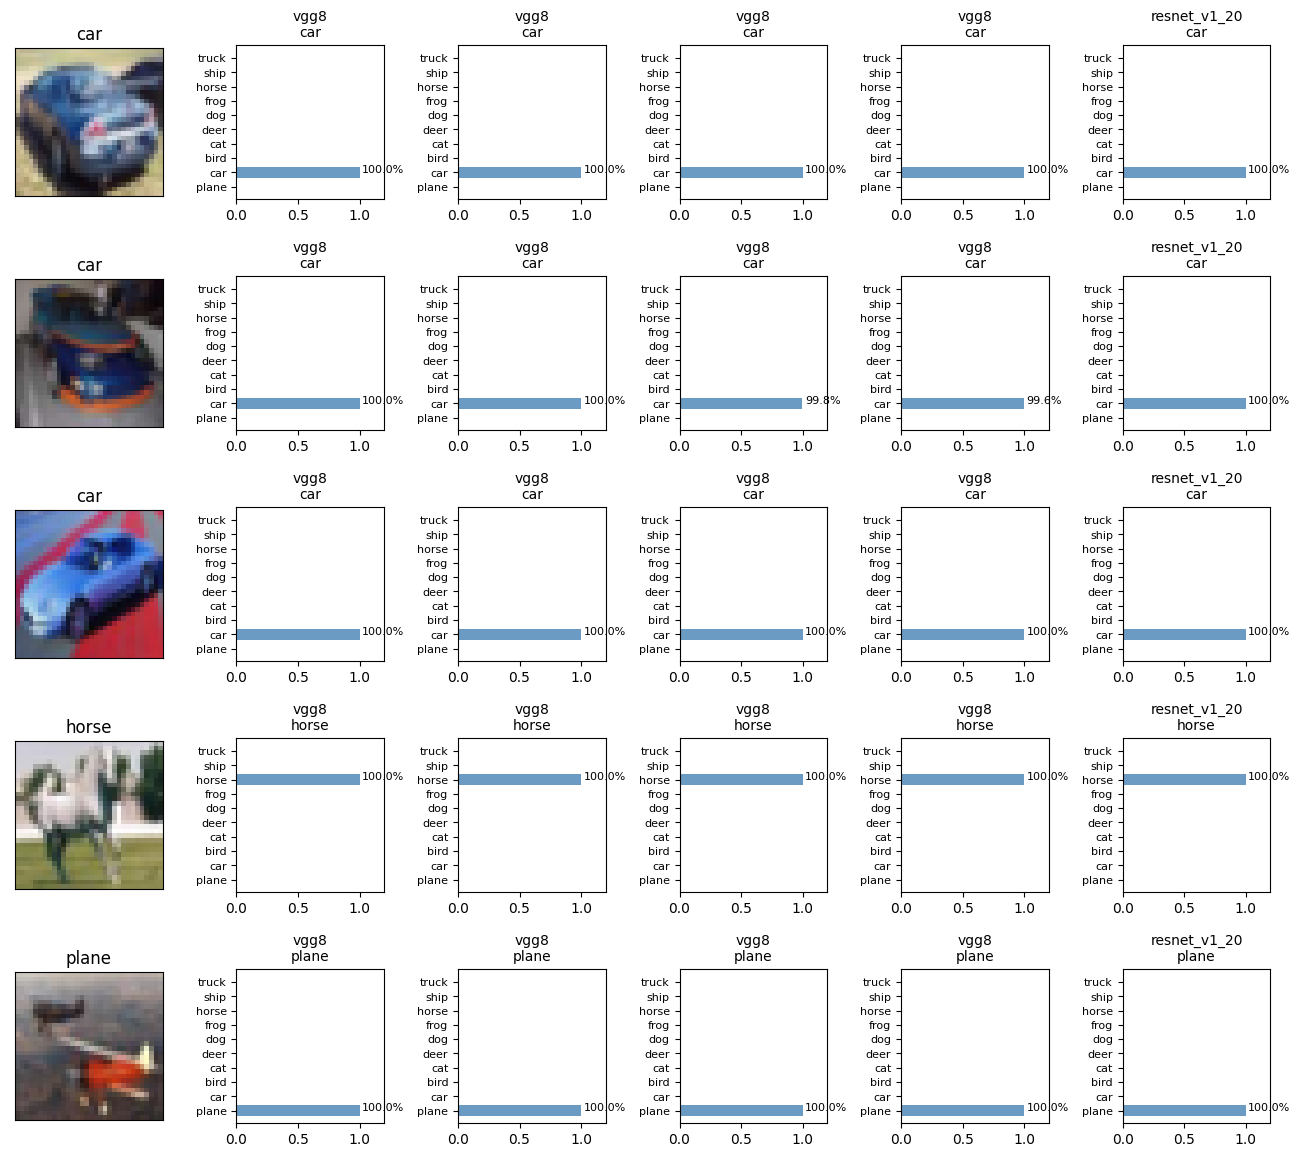

In [28]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 14ms/step


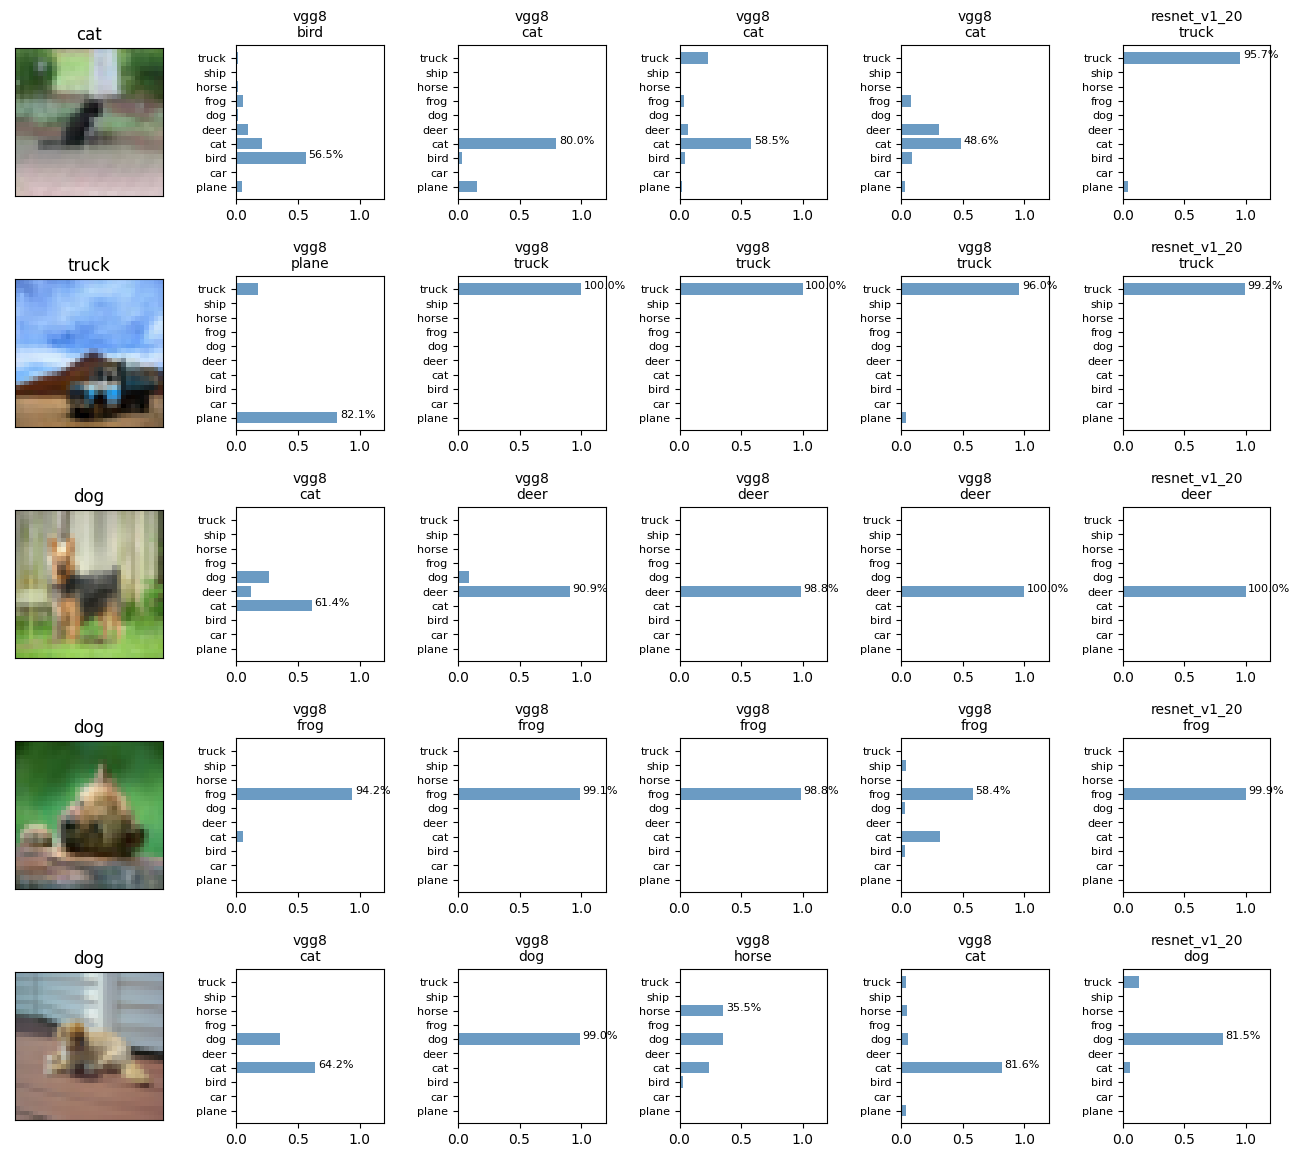

In [29]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [30]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.5896327495574951, 'accuracy': 0.8967999815940857, 'mae': 25.367116928100586}
313/313 [==============================] - 1s 4ms/step
(10000, 10)


In [31]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 1s 4ms/step


precision  recall        f1
plane   0.904245   0.916  0.910084
car     0.944334   0.950  0.947159
bird    0.872802   0.844  0.858160
cat     0.819549   0.763  0.790264
deer    0.889655   0.903  0.896278
dog     0.824832   0.857  0.840608
frog    0.897901   0.941  0.918945
horse   0.941358   0.915  0.927992
ship    0.943775   0.940  0.941884
truck   0.926950   0.939  0.932936

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9042    0.9160    0.9101      1000
         car     0.9443    0.9500    0.9472      1000
        bird     0.8728    0.8440    0.8582      1000
         cat     0.8195    0.7630    0.7903      1000
        deer     0.8897    0.9030    0.8963      1000
         dog     0.8248    0.8570    0.8406      1000
        frog     0.8979    0.9410    0.9189      1000
       horse     0.9414    0.9150    0.9280      1000
        ship     0.9438    0.9400    0.9419      1000
       truck     0.9269    0.9390    0.9329      1000

    accuracy                         0.8968     10000
   macro avg     0.8965    0.8968    0.8964     10000
weighted avg     0.8965    0.8968    0.8964     10000



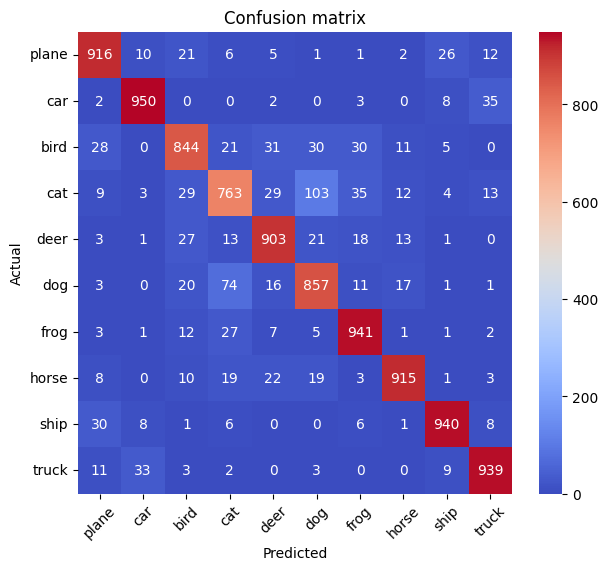

In [32]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [33]:
type(helper.datasets.train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset